# DBBA Coursework 1

#### Name: Teofebano Kristo       
#### Student Number: S2594631

--------------------------------------------------------------------------------------------------------------------------------------------

### Instructions

#### Academic Misconduct

Please remember the good scholarly practice requirements of the University regarding work for
credit. You can find guidance at the School page

https://web.inf.ed.ac.uk/infweb/admin/policies/academic-misconduct

This also has links to the relevant University pages. 

**You are not allowed to collaborate with other students on this assignment or to ask or answer questions about the contents of the assignment. If you do not understand a specific question, ask Valerio and Ogy on Piazza.**

#### Submission Instructions

All the analysis must be done in this Jupyter Notebook and you should have a separate written report (without code) saved in PDF. Please fill out the fields bellow with the necessary code(remember to comment your code well) and discussion where needed. Code will generally
not be marked, but it will be checked by the markers to ensure that all the analysis is properly
done and the work is yours (i.e. there was no plagiarism). Focus on analysing the results you obtain as this is the main part that will be marked. Report your findings in a PDF file where you do not include any code but just the figures obtained and the conclusions you draw, i.e. plots and analysis. You will have to submit your files (final Jupyter Notebook and PDF) on Learn. Name your files with your
student number. For instance, if your student number is S123456789, you must submit a file
S123456789.zip containing the python source code and answers to the questions (PDF).

#### General Instructions 
In this coursework, you will analyse a real-world temporal network based on what you have learned in
class. Many exercises will require you to discuss the results of your analysis, some other will leave
you the choice of which algorithm to use for a particular task. This is by design because this
coursework assesses whether you understand network science and whether you can apply it to
real-world networks. For this reason, if you realise you need to make assumptions to answer a
question, do so and always, always motivate your assumptions and answers!

**Warning:** Some network metrics might require some time to compute. Please consider this when
doing the coursework and allow enough time to perform the required computations. Also
remember that you can use the School’s DICE machines, which can be let to run!

--------------------------------------------------------------------------------------------------------------------------------------------

#### Assignment Premises

You have been hired as a data analyst in the newly founded investment company DBBA Capital and have been tasked with the analysis of the investment patterns of one of our major competitors: Fairholme Capital, managed by Bruce Berkowitz. 

DBBA Capital wants you to evaluate the investment patterns of Fairholme Capital in relation to other superinvestors and evaluate the change in investment patterns during the pandemic. They have provided you with data about different superinvestors and the companies they invested in for each quarter spanning from quarter 1 (Q1) of 2019 to quarter 2 (Q2) of 2023 (that you can find in the folder named "Assignment Data"). 

The first column of each file represents the investors and the remaining columns represent the companies each investor invested in. First, familiarlise yourself with the data, and then, follow the steps bellow to perform the necessary analysis.

**TIP** When you believe it might help, make use of the information you have on the portfolio composition to comment and discuss your results.

# Library Management

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import networkx as nx
%matplotlib inline

import pygraphviz
from networkx.drawing.nx_agraph import graphviz_layout
import matplotlib.pyplot as plt

from tabulate import tabulate
import statistics
import math

from collections import Counter

# Methods

In [2]:
# Drawing Network
def draw_graphviz(G, id, nodecolor, spreadprogram='neato'):
    # init plt     
    plt.figure(id, figsize=(20,15))
    
    # use pydot and graphviz for better layout    
    pos = graphviz_layout(G, prog = spreadprogram)
    color_map = []
    for node in G:
        if node == 'Bruce Berkowitz - Fairholme Capital':
            # highlighting Fairholme Capital with different color             
            color_map.append('orange')
        else: 
            color_map.append(nodecolor)

    nx.draw(G, pos, node_color = color_map, with_labels = True, node_size=1000, font_size=16)
    
    labels = nx.get_edge_attributes(G,'weight')
    nx.draw_networkx_edge_labels(G,pos,edge_labels=labels)
    
    plt.title(id, fontsize=16, fontweight="bold")
    
    # draw
    plt.show()

In [80]:
# Drawing Network with Community
def draw_community(G, id, nodecolors, spreadprogram='neato'):
    # init plt     
    plt.figure(id, figsize=(20,15))
    
    # use pydot and graphviz for better layout    
    pos = graphviz_layout(G, prog = spreadprogram)

    nx.draw(G, pos, node_color = nodecolors, with_labels = True, node_size=1000, font_size=16)
    
    labels = nx.get_edge_attributes(G,'weight')
    nx.draw_networkx_edge_labels(G,pos,edge_labels=labels)
    
    plt.title(id, fontsize=16, fontweight="bold")
    
    # draw
    plt.show()

In [3]:
# Populate Network
def populate_graph(G, dataframe):
    for index, row in dataframe.iterrows():
        investors = dataframe.iloc[:, 0]
        G.add_nodes_from(investors);
        
    for i in range(len(investors)):
        investori = dataframe.iloc[i,0]
        stocksi = dataframe.iloc[i,1:]
        clean_stocksi = stocksi.dropna()
        
        for j in range(i + 1, len(investors)):
            investorj = dataframe.iloc[j,0]
            stocksj = dataframe.iloc[j,1:]
            clean_stocksj = stocksj.dropna()
            
            common_values = list(set(clean_stocksi) & set(clean_stocksj))
            
            if len(common_values) > 0:
                G.add_edge(investori, investorj)
                G[investori][investorj]['weight'] = len(common_values)
                
def add_strength_to_nodes(G):
    strengths = {}
    for node in G.nodes():
        strength = sum(G[node][neighbor]['weight'] for neighbor in G.neighbors(node))
        strengths[node] = strength
    
    nx.set_node_attributes(G, strengths, "strength")
    
def add_clustering_to_nodes(G):
    clusterings = {}
    for node in G.nodes():
        clustering = nx.clustering(G, node)
        clusterings[node] = clustering
    
    nx.set_node_attributes(G, clusterings, "clustering")

In [4]:
# Extract Giant Component
def extract_giant_component_from_graph(G):
    G_CC = sorted(nx.connected_components(G), key=len, reverse=True)
    Giant_G = G.subgraph(G_CC[0])
    
    return Giant_G

In [5]:
# Build Ego Network
def build_ego_network_for_node(G, node):
    return nx.ego_graph(G, node)

In [6]:
# Calculate Network Summary Per Graph
def get_network_summary_for_graph(G):
    nodesCount = G.number_of_nodes()
    
    edgesCount = G.number_of_edges()

    density = nx.density(G)
    
    averageClustering = nx.average_clustering(G)

    degrees = [val for (node, val) in G.degree()]
    sumDegrees = sum(degrees)
    averageDegrees = sumDegrees / nodesCount

    # index 0 is node name, index 1 is weights for that particular node
    weights = G.degree(weight='weight')
    averageStrength = sum(weight[1] for weight in weights) / nodesCount 

    degreeAssortativity = nx.degree_assortativity_coefficient(G)
    
    strengthAssortativity = nx.numeric_assortativity_coefficient(G, "strength")
    
    clusteringAssortativity = nx.numeric_assortativity_coefficient(G, "clustering")
    
    return {
        "nodesCount": nodesCount, 
        "edgesCount": edgesCount, 
        "density": density, 
        "averageClustering": averageClustering, 
        "averageDegrees": averageDegrees, 
        "averageStrength": averageStrength, 
        "degreeAssortativity": degreeAssortativity, 
        "strengthAssortativity": strengthAssortativity, 
        "clusteringAssortativity": clusteringAssortativity
    }


In [7]:
# Print Statistic Summary for Multiple Graphs
def get_statistics_for_graphs(networkSummary):
    # Nodes Count
    maxValNodesCount = max(quarterData['nodesCount'] for quarterData in networkSummary.values())
    minValNodesCount = min(quarterData['nodesCount'] for quarterData in networkSummary.values())
    meanValNodesCount = statistics.mean(quarterData['nodesCount'] for quarterData in networkSummary.values())
    medianValNodesCount = statistics.median(quarterData['nodesCount'] for quarterData in networkSummary.values())
    standardDeviationValNodesCount = statistics.stdev(quarterData['nodesCount'] for quarterData in networkSummary.values())
    
    # Edges Count
    maxValEdgesCount = max(quarterData['edgesCount'] for quarterData in networkSummary.values())
    minValEdgesCount = min(quarterData['edgesCount'] for quarterData in networkSummary.values())
    meanValEdgesCount = statistics.mean(quarterData['edgesCount'] for quarterData in networkSummary.values())
    medianValEdgesCount = statistics.median(quarterData['edgesCount'] for quarterData in networkSummary.values())
    standardDeviationValEdgesCount = statistics.stdev(quarterData['edgesCount'] for quarterData in networkSummary.values())
    
    # Density
    maxValDensity = max(quarterData['density'] for quarterData in networkSummary.values())
    minValDensity = min(quarterData['density'] for quarterData in networkSummary.values())
    meanValDensity = statistics.mean(quarterData['density'] for quarterData in networkSummary.values())
    medianValDensity = statistics.median(quarterData['density'] for quarterData in networkSummary.values())
    standardDeviationValDensity = statistics.stdev(quarterData['density'] for quarterData in networkSummary.values())
    
    # Average Clustering
    maxValAverageClustering = max(quarterData['averageClustering'] for quarterData in networkSummary.values())
    minValAverageClustering = min(quarterData['averageClustering'] for quarterData in networkSummary.values())
    meanValAverageClustering = statistics.mean(quarterData['averageClustering'] for quarterData in networkSummary.values())
    medianValAverageClustering = statistics.median(quarterData['averageClustering'] for quarterData in networkSummary.values())
    standardDeviationValAverageClustering = statistics.stdev(quarterData['averageClustering'] for quarterData in networkSummary.values())
    
    # Average Degrees
    maxValAverageDegrees = max(quarterData['averageDegrees'] for quarterData in networkSummary.values())
    minValAverageDegrees = min(quarterData['averageDegrees'] for quarterData in networkSummary.values())
    meanValAverageDegrees = statistics.mean(quarterData['averageDegrees'] for quarterData in networkSummary.values())
    medianValAverageDegrees = statistics.median(quarterData['averageDegrees'] for quarterData in networkSummary.values())
    standardDeviationValAverageDegrees = statistics.stdev(quarterData['averageDegrees'] for quarterData in networkSummary.values())
    
    # Average Strength
    maxValAverageStrength = max(quarterData['averageStrength'] for quarterData in networkSummary.values())
    minValAverageStrength = min(quarterData['averageStrength'] for quarterData in networkSummary.values())
    meanValAverageStrength = statistics.mean(quarterData['averageStrength'] for quarterData in networkSummary.values())
    medianValAverageStrength = statistics.median(quarterData['averageStrength'] for quarterData in networkSummary.values())
    standardDeviationValAverageStrength = statistics.stdev(quarterData['averageStrength'] for quarterData in networkSummary.values())
    
    # Degree Assortativity
    data = [quarterData['degreeAssortativity'] for quarterData in networkSummary.values()]
    filteredData = [x for x in data if not math.isnan(x)]
    
    maxValDegreeAssortativity = max(filteredData)
    minValDegreeAssortativity = min(filteredData)
    meanValDegreeAssortativity = statistics.mean(filteredData)
    medianValDegreeAssortativity = statistics.median(filteredData)
    
    standardDeviationValDegreeAssortativity = 'N/A'
    if len(filteredData) > 1 :
        standardDeviationValDegreeAssortativity = statistics.stdev(filteredData)
    
    # Strength Assortativity
    data = [quarterData['strengthAssortativity'] for quarterData in networkSummary.values()]
    filteredData = [x for x in data if not math.isnan(x)]
    
    maxValStrengthAssortativity = max(filteredData)
    minValStrengthAssortativity = min(filteredData)
    meanValStrengthAssortativity = statistics.mean(filteredData)
    medianValStrengthAssortativity = statistics.median(filteredData)
    
    standardDeviationValStrengthAssortativity = 'N/A'
    if len(filteredData) > 1 :
        standardDeviationValStrengthAssortativity = statistics.stdev(filteredData)
    
    # Clustering Assortativity
    data = [quarterData['clusteringAssortativity'] for quarterData in networkSummary.values()]
    filteredData = [x for x in data if not math.isnan(x)]
    
    maxValClusteringAssortativity = max(filteredData)
    minValClusteringAssortativity = min(filteredData)
    meanValClusteringAssortativity = statistics.mean(filteredData)
    medianValClusteringAssortativity = statistics.median(filteredData)
    
    standardDeviationValClusteringAssortativity = 'N/A'
    if len(filteredData) > 1 :
        standardDeviationValClusteringAssortativity = statistics.stdev(filteredData)
    
    data = [["# Nodes", maxValNodesCount, minValNodesCount, meanValNodesCount, medianValNodesCount, standardDeviationValNodesCount],
           ["# Edges", maxValEdgesCount, minValEdgesCount, meanValEdgesCount, medianValEdgesCount, standardDeviationValEdgesCount],
           ["Density", maxValDensity, minValDensity, meanValDensity, medianValDensity, standardDeviationValDensity],
           ["Avg. Clustering", maxValAverageClustering, minValAverageClustering, meanValAverageClustering, medianValAverageClustering, standardDeviationValAverageClustering],
           ["Avg. Degrees", maxValAverageDegrees, minValAverageDegrees, meanValAverageDegrees, medianValAverageDegrees, standardDeviationValAverageDegrees],
           ["Avg. Strength", maxValAverageStrength, minValAverageStrength, meanValAverageStrength, medianValAverageStrength, standardDeviationValAverageStrength],
           ["Degree Assort.", maxValDegreeAssortativity, minValDegreeAssortativity, meanValDegreeAssortativity, medianValDegreeAssortativity, standardDeviationValDegreeAssortativity],
           ["Strength Assort.", maxValStrengthAssortativity, minValStrengthAssortativity, meanValStrengthAssortativity, medianValStrengthAssortativity, standardDeviationValStrengthAssortativity],
           ["Clustering Assort.", maxValClusteringAssortativity, minValClusteringAssortativity, meanValClusteringAssortativity, medianValClusteringAssortativity, standardDeviationValClusteringAssortativity]]
    print (tabulate(data, headers=["Properties", 
                                   "max", 
                                   "min", 
                                   "mean", 
                                   "median", 
                                   "SD"
                                  ]))

In [8]:
# Draw Degree Distribution
def plot_degree_distribution(degrees, title):
    plt.title(title)
    
    bins = np.logspace(np.log10(1), np.log10(1e2), num=20)
    
    plt.hist([deg for _, deg in degrees], bins)
    
    plt.xlabel('degree')
    plt.ylabel('frequency')
    plt.xscale('log')
    plt.yscale('log')
    
    plt.figure(figsize = (15, 3))
    
    plt.show()

In [9]:
# Draw Strength Distribution
def plot_strength_distribution(strengths, title):
    plt.title(title)
    
    bins = np.logspace(np.log10(1), np.log10(1e2), num=20)
    
    plt.hist(list(strengths.values()), bins)
    
    plt.xlabel('strength')
    plt.ylabel('frequency')
    plt.xscale('log')
    plt.yscale('log')
    
    plt.figure(figsize = (15, 3))
    
    plt.show()

#### Part 1: Network Creation

**Task 1.1 (7 marks)**<br>
In the field below, load the first Excel dataset ("2019_Q1.xlsx") and create a network out of the investors and companies in the following manner:

- the nodes of the network are all the investors in the first column of the dataset
- two investors (nodes) are connected with an edge if the have invested in the same company (e.g. Christopher Bloomstran - Semper Augustus and David Abrams - Abrams Capital Management will be connected because they both invested in GOOGL). 
- if two investors have invested in more than one common comapny, do *not* assign multiple edges between them. Instead, assign the number of common companies they have invested in as a weight to the edge connecting them.

After you built the network, extract the largest connected component and plot it. Remember to add the edge weights in your plot.

In [10]:
#CODE HERE
df_2019_Q1 = pd.read_excel('./Assignment_Data/2019_Q1.xlsx', header=None)

G_2019_Q1 = nx.Graph()
populate_graph(G_2019_Q1, df_2019_Q1)

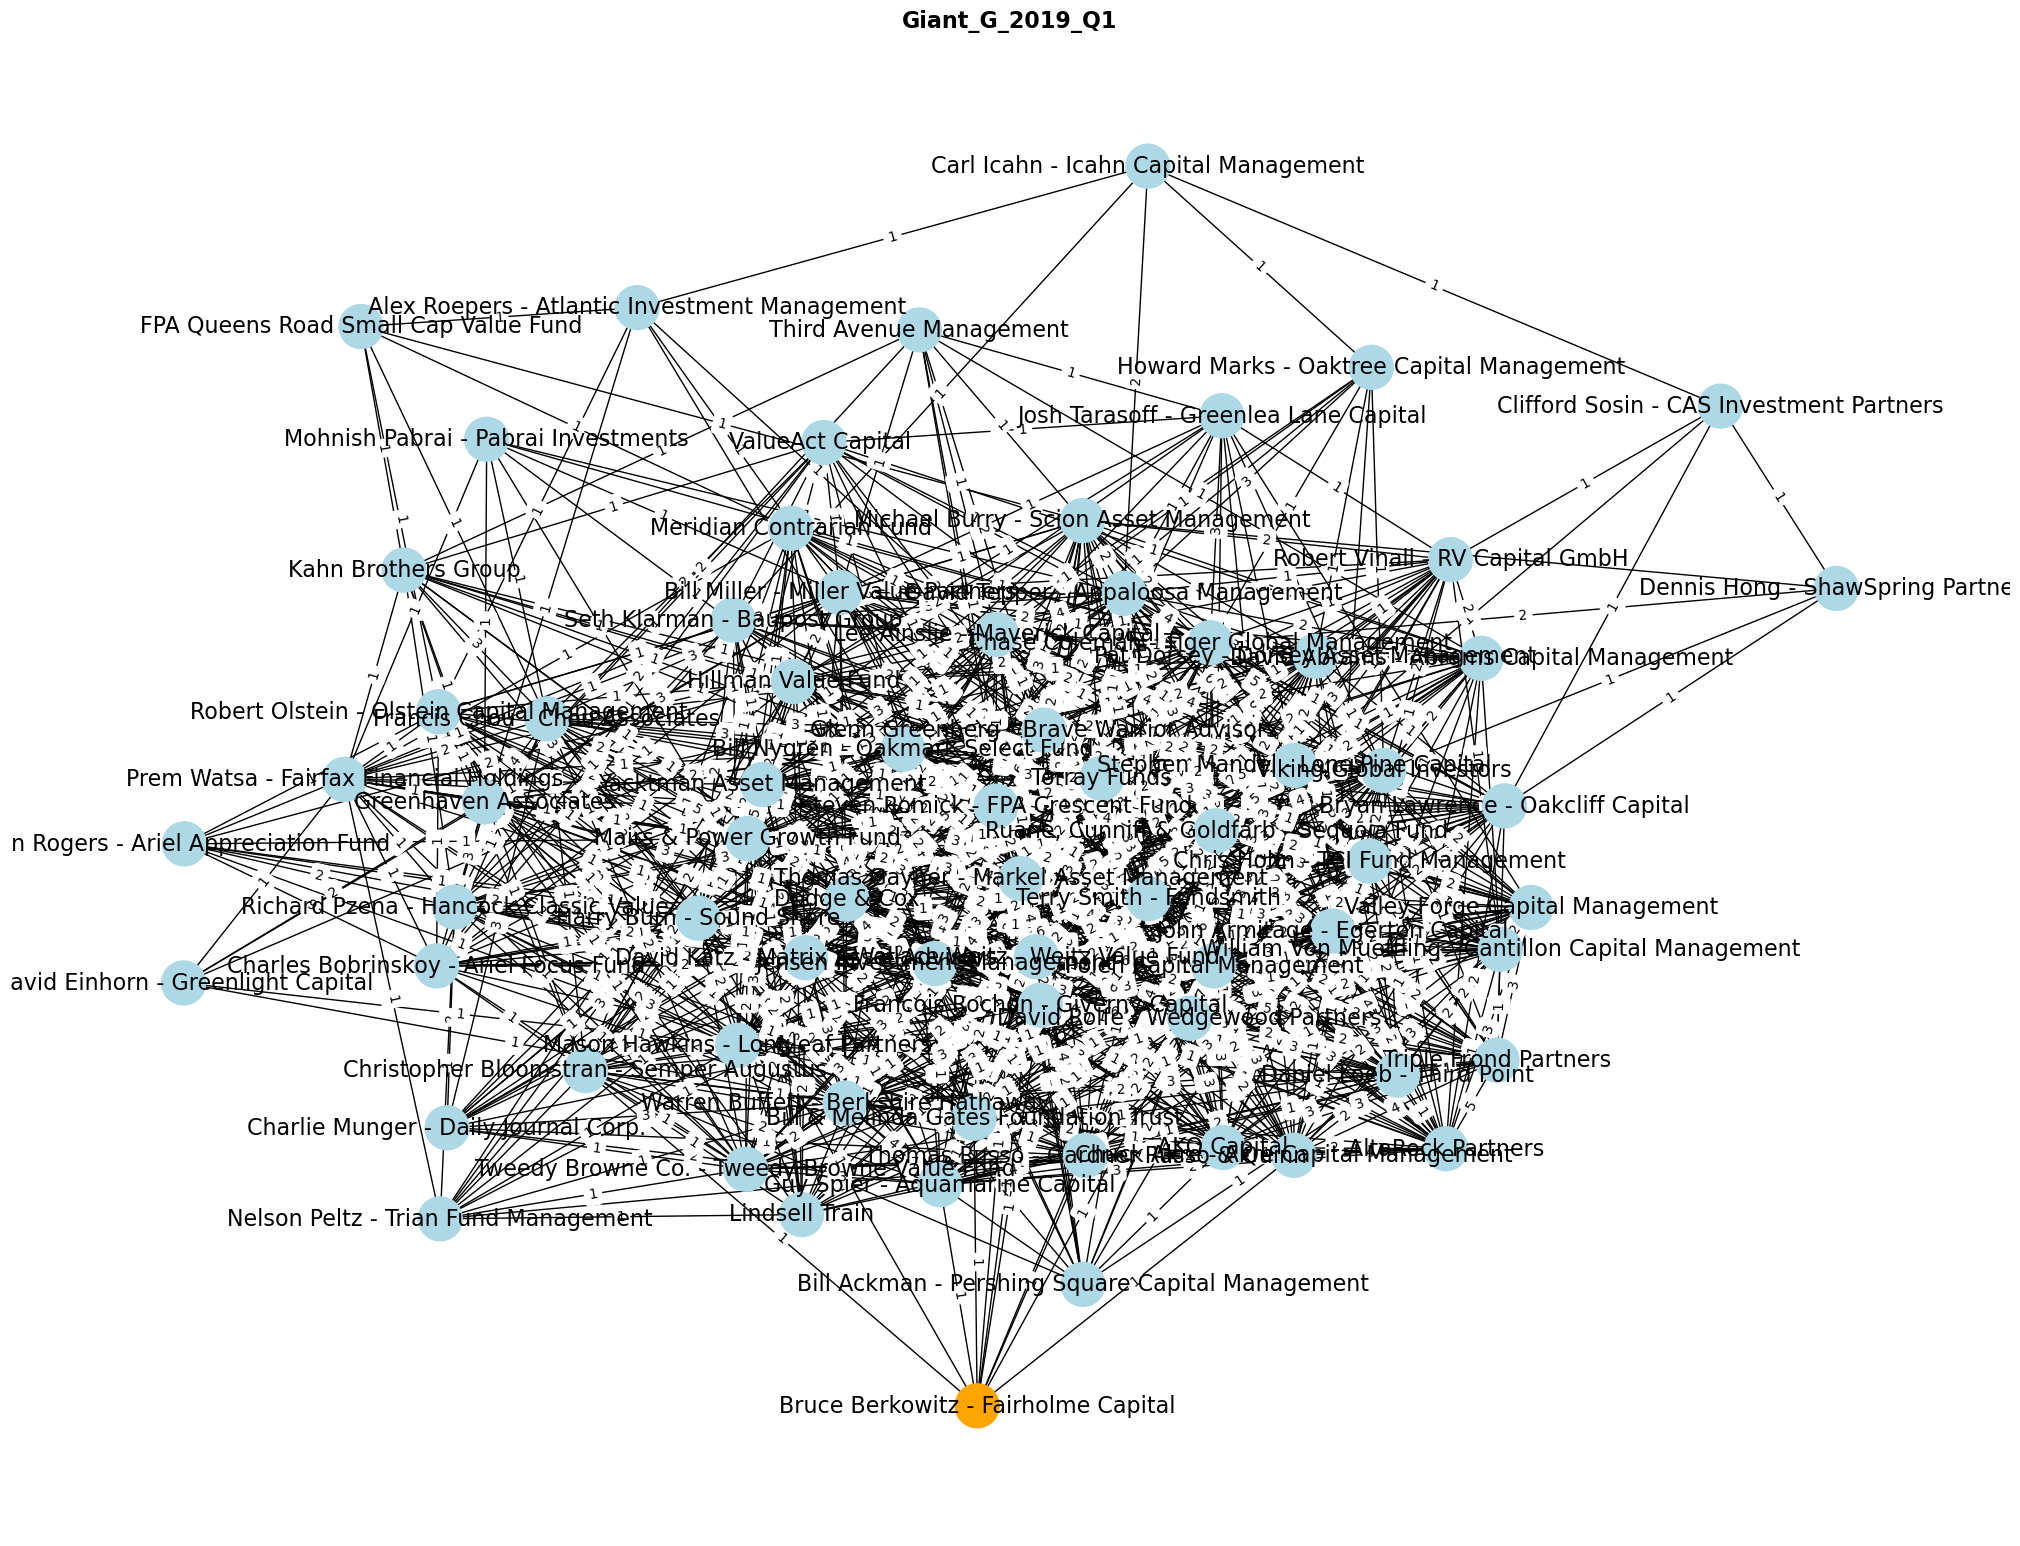

In [11]:
Giant_G_2019_Q1 = extract_giant_component_from_graph(G_2019_Q1)

draw_graphviz(Giant_G_2019_Q1, 'Giant_G_2019_Q1', 'lightblue')

**Task 1.2 (3 marks)** <br>
Obtain the ego-network of 'Bruce Berkowitz - Fairholme Capital' and plot it.

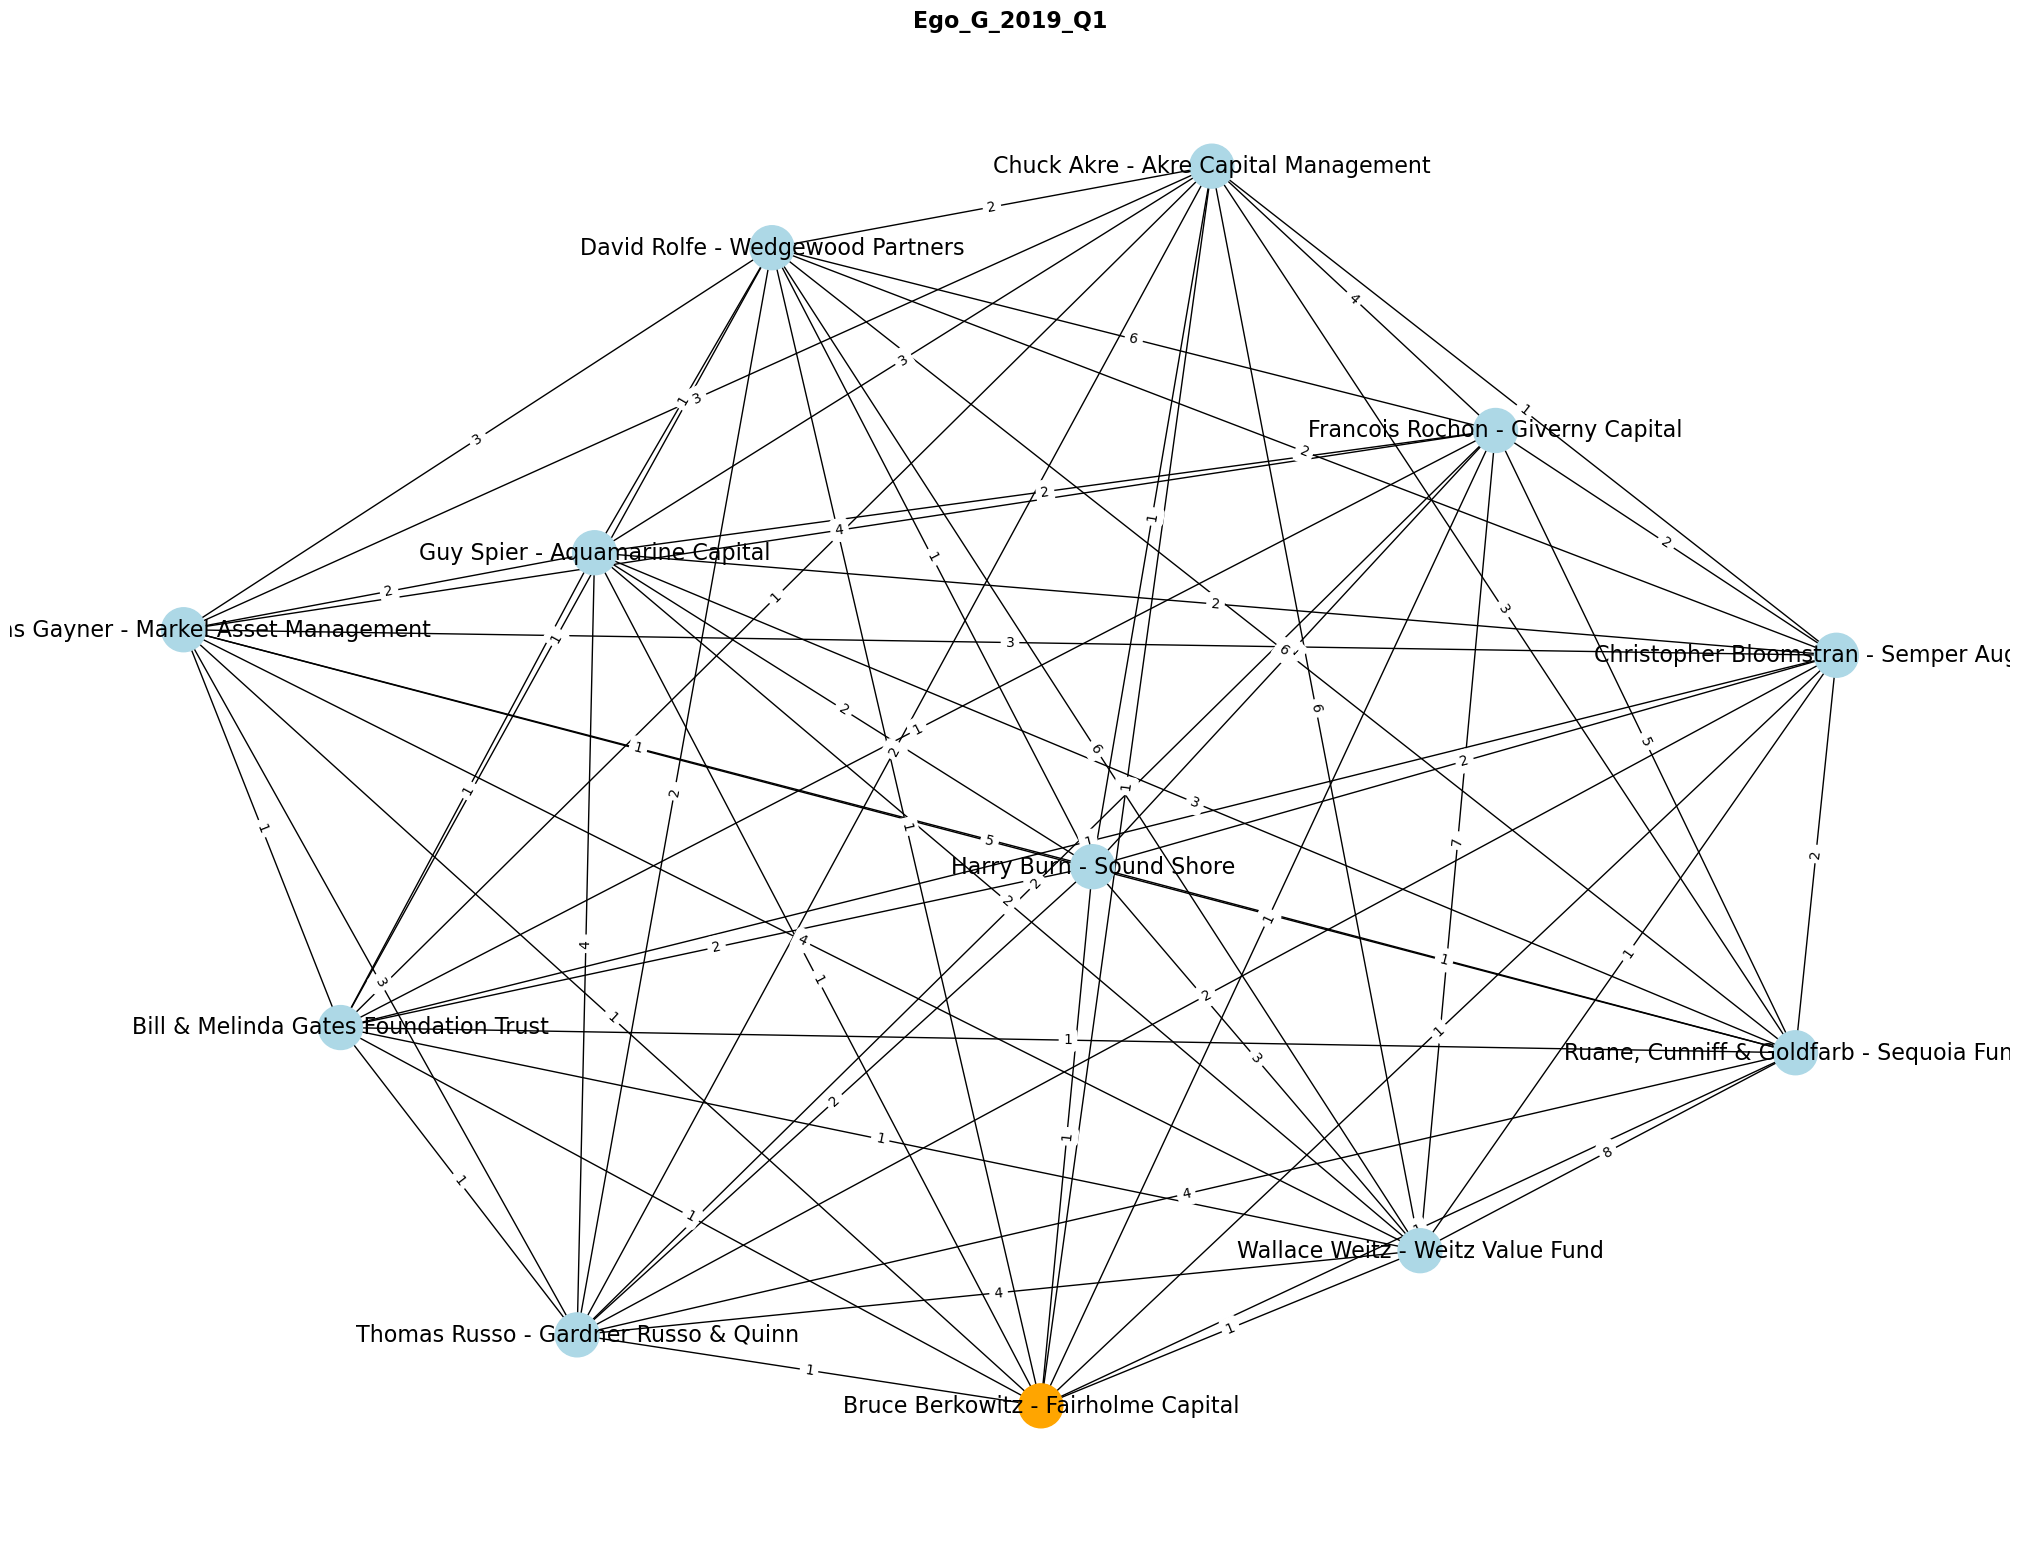

In [12]:
# CODE HERE
Ego_G_2019_Q1 = build_ego_network_for_node(G_2019_Q1, 'Bruce Berkowitz - Fairholme Capital')

draw_graphviz(Ego_G_2019_Q1, 'Ego_G_2019_Q1', 'lightblue', 'fdp')

#### Part 2: Basic Network Analysis

**Task 2.1 (15 marks)** <br>
Now that you know how to build the network for a single quarter and get its largest connected component, repeat the procedure for all the other quarters. For both the whole network and the ego-network, produce a table with the summary statistics (i.e. mean, max, min, and standard deviation) of the following network quantities:

- Number of nodes
- Number of links
- Density
- Average clustering coefficient
- Average degrees
- Average strength
- Assortativity

If you need to make any assumption or decision regarding the metric to use to compute any of these quantities, clearly motivate it.

#### Assumption
1. Because we are analyzing weighted network, I add Numeric Assortativity for Strength to deepen the analysis
2. Because the network is created using Assortative Approach (Edges represent common interest between nodes), I add Numeric Assortativity for Clustering to deepen the analysis
3. I use Whole Network instead of Giant Component as the comparator for Ego Network because I want to do global vs local perspectives comparison. Global perspective is more represented by Whole Network rather than Giant Component in this scenario
4. Summary statistics is calculated by combining data from multiple quarters. There are three time frames that I use to do the calculation, which are Whole Data (Q1 2019 - Q2 2023), Pre-Covid (Q1 2019 - Q4 2019), and During-Covid (Q1 2020 - Q2 2023). The reason is because Covid is a global issue and potentially disrupts the temporal networks after it hits. Therefore splitting the time frames will avoid extreme shifts in summary statistics. There will be 6 summaries
- Whole Network All-Time
- Whole Network Pre-Covid
- Whole Network During-Covid
- Ego Network All-Time
- Ego Network Pre-Covid
- Ego Network Post-Covid


In [13]:
#CODE HERE
summaryWholeAllTime = {}
summaryEgoAllTime = {}

summaryWholePreCovid = {}
summaryEgoPreCovid = {}

summaryWholeDuringCovid = {}
summaryEgoDuringCovid = {}

In [14]:
# 2019_Q1 Whole
add_strength_to_nodes(G_2019_Q1)
add_clustering_to_nodes(G_2019_Q1)

ns_G_2019_Q1 = get_network_summary_for_graph(G_2019_Q1)
summaryWholeAllTime["2019_Q1"] = ns_G_2019_Q1
summaryWholePreCovid["2019_Q1"] = ns_G_2019_Q1
print(ns_G_2019_Q1)

# 2019_Q1 Ego
add_strength_to_nodes(Ego_G_2019_Q1)
add_clustering_to_nodes(Ego_G_2019_Q1)

ns_Ego_G_2019_Q1 = get_network_summary_for_graph(Ego_G_2019_Q1)
summaryEgoAllTime["2019_Q1"] = ns_Ego_G_2019_Q1
summaryEgoPreCovid["2019_Q1"] = ns_Ego_G_2019_Q1
print(ns_Ego_G_2019_Q1)

{'nodesCount': 71, 'edgesCount': 1070, 'density': 0.4305835010060362, 'averageClustering': 0.645886845865244, 'averageDegrees': 30.140845070422536, 'averageStrength': 57.66197183098591, 'degreeAssortativity': 0.05824723419739148, 'strengthAssortativity': 0.03938655914746915, 'clusteringAssortativity': 0.15722849551704976}
{'nodesCount': 12, 'edgesCount': 66, 'density': 1.0, 'averageClustering': 1.0, 'averageDegrees': 11.0, 'averageStrength': 26.333333333333332, 'degreeAssortativity': nan, 'strengthAssortativity': -0.09090909090908846, 'clusteringAssortativity': nan}


/Users/teofebano/anaconda3/lib/python3.11/site-packages/networkx/algorithms/assortativity/correlation.py:298: RuntimeWarning: invalid value encountered in scalar divide
  return (xy * (M - ab)).sum() / np.sqrt(vara * varb)


In [15]:
df_2019_Q2 = pd.read_excel('./Assignment_Data/2019_Q2.xlsx', header=None)

G_2019_Q2 = nx.Graph()

# 2019_Q2 Whole
populate_graph(G_2019_Q2, df_2019_Q2)

# 2019_Q2 Giant
Giant_G_2019_Q2 = extract_giant_component_from_graph(G_2019_Q2)

# 2019_Q2 Ego
Ego_G_2019_Q2 = build_ego_network_for_node(G_2019_Q2, 'Bruce Berkowitz - Fairholme Capital')

# Add Node Attributes
add_strength_to_nodes(G_2019_Q2)
add_clustering_to_nodes(G_2019_Q2)
add_strength_to_nodes(Ego_G_2019_Q2)
add_clustering_to_nodes(Ego_G_2019_Q2)

# Calculate Summary
ns_G_2019_Q2 = get_network_summary_for_graph(G_2019_Q2)
ns_Ego_G_2019_Q2 = get_network_summary_for_graph(Ego_G_2019_Q2)

summaryWholeAllTime["2019_Q2"] = ns_G_2019_Q2
summaryEgoAllTime["2019_Q2"] = ns_Ego_G_2019_Q2

summaryWholePreCovid["2019_Q2"] = ns_G_2019_Q2
summaryEgoPreCovid["2019_Q2"] = ns_Ego_G_2019_Q2

print(ns_G_2019_Q2)
print(ns_Ego_G_2019_Q2)

{'nodesCount': 73, 'edgesCount': 1086, 'density': 0.4132420091324201, 'averageClustering': 0.6478984359157354, 'averageDegrees': 29.753424657534246, 'averageStrength': 56.32876712328767, 'degreeAssortativity': 0.02314822663497052, 'strengthAssortativity': -0.0027106339552464, 'clusteringAssortativity': 0.0760815828016848}
{'nodesCount': 14, 'edgesCount': 91, 'density': 1.0, 'averageClustering': 1.0, 'averageDegrees': 13.0, 'averageStrength': 31.428571428571427, 'degreeAssortativity': nan, 'strengthAssortativity': -0.07692307692307543, 'clusteringAssortativity': nan}


/Users/teofebano/anaconda3/lib/python3.11/site-packages/networkx/algorithms/assortativity/correlation.py:298: RuntimeWarning: invalid value encountered in scalar divide
  return (xy * (M - ab)).sum() / np.sqrt(vara * varb)


In [16]:
df_2019_Q3 = pd.read_excel('./Assignment_Data/2019_Q3.xlsx', header=None)

G_2019_Q3 = nx.Graph()

# 2019_Q3 Whole
populate_graph(G_2019_Q3, df_2019_Q3)

# 2019_Q3 Giant
Giant_2019_Q3 = extract_giant_component_from_graph(G_2019_Q3)

# 2019_Q3 Ego
Ego_G_2019_Q3 = build_ego_network_for_node(G_2019_Q3, 'Bruce Berkowitz - Fairholme Capital')

# Add Node Attributes
add_strength_to_nodes(G_2019_Q3)
add_clustering_to_nodes(G_2019_Q3)
add_strength_to_nodes(Ego_G_2019_Q3)
add_clustering_to_nodes(Ego_G_2019_Q3)

# Calculate Summary
ns_G_2019_Q3 = get_network_summary_for_graph(G_2019_Q3)
ns_Ego_G_2019_Q3 = get_network_summary_for_graph(Ego_G_2019_Q3)

summaryWholeAllTime["2019_Q3"] = ns_G_2019_Q3
summaryEgoAllTime["2019_Q3"] = ns_Ego_G_2019_Q3

summaryWholePreCovid["2019_Q3"] = ns_G_2019_Q3
summaryEgoPreCovid["2019_Q3"] = ns_Ego_G_2019_Q3

print(ns_G_2019_Q3)
print(ns_Ego_G_2019_Q3)

{'nodesCount': 74, 'edgesCount': 1064, 'density': 0.39392817475009256, 'averageClustering': 0.6354141765282975, 'averageDegrees': 28.756756756756758, 'averageStrength': 53.351351351351354, 'degreeAssortativity': 0.035976024481126086, 'strengthAssortativity': 0.027168428834173655, 'clusteringAssortativity': 0.08922959576842959}
{'nodesCount': 16, 'edgesCount': 108, 'density': 0.9, 'averageClustering': 0.9540293040293042, 'averageDegrees': 13.5, 'averageStrength': 30.125, 'degreeAssortativity': -0.13297872340425956, 'strengthAssortativity': -0.08376129734534635, 'clusteringAssortativity': -0.11336333751793982}


In [17]:
df_2019_Q4 = pd.read_excel('./Assignment_Data/2019_Q4.xlsx', header=None)

G_2019_Q4 = nx.Graph()

# 2019_Q4 Whole
populate_graph(G_2019_Q4, df_2019_Q4)

# 2019_Q4 Giant
Giant_2019_Q4 = extract_giant_component_from_graph(G_2019_Q4)

# 2019_Q4 Ego
Ego_G_2019_Q4 = build_ego_network_for_node(G_2019_Q4, 'Bruce Berkowitz - Fairholme Capital')

# Add Node Attributes
add_strength_to_nodes(G_2019_Q4)
add_clustering_to_nodes(G_2019_Q4)
add_strength_to_nodes(Ego_G_2019_Q4)
add_clustering_to_nodes(Ego_G_2019_Q4)

# Calculate Summary
ns_G_2019_Q4 = get_network_summary_for_graph(G_2019_Q4)
ns_Ego_G_2019_Q4 = get_network_summary_for_graph(Ego_G_2019_Q4)

summaryWholeAllTime["2019_Q4"] = ns_G_2019_Q4
summaryEgoAllTime["2019_Q4"] = ns_Ego_G_2019_Q4

summaryWholePreCovid["2019_Q4"] = ns_G_2019_Q4
summaryEgoPreCovid["2019_Q4"] = ns_Ego_G_2019_Q4

print(ns_G_2019_Q4)
print(ns_Ego_G_2019_Q4)

{'nodesCount': 77, 'edgesCount': 1187, 'density': 0.40567327409432674, 'averageClustering': 0.6498732353192321, 'averageDegrees': 30.83116883116883, 'averageStrength': 56.64935064935065, 'degreeAssortativity': 0.027386367027512293, 'strengthAssortativity': 0.010833952147910726, 'clusteringAssortativity': 0.04360350786368307}
{'nodesCount': 15, 'edgesCount': 105, 'density': 1.0, 'averageClustering': 1.0, 'averageDegrees': 14.0, 'averageStrength': 34.13333333333333, 'degreeAssortativity': nan, 'strengthAssortativity': -0.0714285714285706, 'clusteringAssortativity': nan}


/Users/teofebano/anaconda3/lib/python3.11/site-packages/networkx/algorithms/assortativity/correlation.py:298: RuntimeWarning: invalid value encountered in scalar divide
  return (xy * (M - ab)).sum() / np.sqrt(vara * varb)


In [18]:
df_2020_Q1 = pd.read_excel('./Assignment_Data/2020_Q1.xlsx', header=None)

G_2020_Q1 = nx.Graph()

# 2020_Q1 Whole
populate_graph(G_2020_Q1, df_2020_Q1)

# 2020_Q1 Giant
Giant_2020_Q1 = extract_giant_component_from_graph(G_2020_Q1)

# 2020_Q1 Ego
Ego_G_2020_Q1 = build_ego_network_for_node(G_2020_Q1, 'Bruce Berkowitz - Fairholme Capital')

# Add Node Attributes
add_strength_to_nodes(G_2020_Q1)
add_clustering_to_nodes(G_2020_Q1)
add_strength_to_nodes(Ego_G_2020_Q1)
add_clustering_to_nodes(Ego_G_2020_Q1)

# Calculate Summary
ns_G_2020_Q1 = get_network_summary_for_graph(G_2020_Q1)
ns_Ego_G_2020_Q1 = get_network_summary_for_graph(Ego_G_2020_Q1)

summaryWholeAllTime["2020_Q1"] = ns_G_2020_Q1
summaryEgoAllTime["2020_Q1"] = ns_Ego_G_2020_Q1

summaryWholeDuringCovid["2020_Q1"] = ns_G_2020_Q1
summaryEgoDuringCovid["2020_Q1"] = ns_Ego_G_2020_Q1

print(ns_G_2020_Q1)
print(ns_Ego_G_2020_Q1)

{'nodesCount': 77, 'edgesCount': 1378, 'density': 0.4709501025290499, 'averageClustering': 0.6946550505374036, 'averageDegrees': 35.79220779220779, 'averageStrength': 71.01298701298701, 'degreeAssortativity': 0.040650982494845396, 'strengthAssortativity': 0.019799657469847447, 'clusteringAssortativity': 0.12907896862899645}
{'nodesCount': 18, 'edgesCount': 129, 'density': 0.8431372549019608, 'averageClustering': 0.8959619175305451, 'averageDegrees': 14.333333333333334, 'averageStrength': 35.111111111111114, 'degreeAssortativity': -0.17629179331308698, 'strengthAssortativity': -0.04067850297573493, 'clusteringAssortativity': 0.14571848434514742}


In [19]:
df_2020_Q2 = pd.read_excel('./Assignment_Data/2020_Q2.xlsx', header=None)

G_2020_Q2 = nx.Graph()

# 2020_Q2 Whole
populate_graph(G_2020_Q2, df_2020_Q2)

# 2020_Q2 Giant
Giant_2020_Q2 = extract_giant_component_from_graph(G_2020_Q2)

# 2020_Q2 Ego
Ego_G_2020_Q2 = build_ego_network_for_node(G_2020_Q2, 'Bruce Berkowitz - Fairholme Capital')

# Add Node Attributes
add_strength_to_nodes(G_2020_Q2)
add_clustering_to_nodes(G_2020_Q2)
add_strength_to_nodes(Ego_G_2020_Q2)
add_clustering_to_nodes(Ego_G_2020_Q2)

# Calculate Summary
ns_G_2020_Q2 = get_network_summary_for_graph(G_2020_Q2)
ns_Ego_G_2020_Q2 = get_network_summary_for_graph(Ego_G_2020_Q2)

summaryWholeAllTime["2020_Q2"] = ns_G_2020_Q2
summaryEgoAllTime["2020_Q2"] = ns_Ego_G_2020_Q2

summaryWholeDuringCovid["2020_Q2"] = ns_G_2020_Q2
summaryEgoDuringCovid["2020_Q2"] = ns_Ego_G_2020_Q2


print(ns_G_2020_Q2)
print(ns_Ego_G_2020_Q2)

{'nodesCount': 77, 'edgesCount': 1360, 'density': 0.46479835953520166, 'averageClustering': 0.7174999812017033, 'averageDegrees': 35.324675324675326, 'averageStrength': 72.31168831168831, 'degreeAssortativity': 0.046580943451144385, 'strengthAssortativity': 0.013681388971622523, 'clusteringAssortativity': 0.07852436822515907}
{'nodesCount': 21, 'edgesCount': 173, 'density': 0.8238095238095238, 'averageClustering': 0.927165837095072, 'averageDegrees': 16.476190476190474, 'averageStrength': 42.0, 'degreeAssortativity': -0.14493554582257986, 'strengthAssortativity': -0.04348139763995684, 'clusteringAssortativity': -0.15435927830811966}


In [20]:
df_2020_Q3 = pd.read_excel('./Assignment_Data/2020_Q3.xlsx', header=None)

G_2020_Q3 = nx.Graph()

# 2020_Q3 Whole
populate_graph(G_2020_Q3, df_2020_Q3)

# 2020_Q3 Giant
Giant_2020_Q3 = extract_giant_component_from_graph(G_2020_Q3)

# 2020_Q3 Ego
Ego_G_2020_Q3 = build_ego_network_for_node(G_2020_Q3, 'Bruce Berkowitz - Fairholme Capital')

# Add Node Attributes
add_strength_to_nodes(G_2020_Q3)
add_clustering_to_nodes(G_2020_Q3)
add_strength_to_nodes(Ego_G_2020_Q3)
add_clustering_to_nodes(Ego_G_2020_Q3)

# Calculate Summary
ns_G_2020_Q3 = get_network_summary_for_graph(G_2020_Q3)
ns_Ego_G_2020_Q3 = get_network_summary_for_graph(Ego_G_2020_Q3)

summaryWholeAllTime["2020_Q3"] = ns_G_2020_Q3
summaryEgoAllTime["2020_Q3"] = ns_Ego_G_2020_Q3

summaryWholeDuringCovid["2020_Q3"] = ns_G_2020_Q3
summaryEgoDuringCovid["2020_Q3"] = ns_Ego_G_2020_Q3

print(ns_G_2020_Q3)
print(ns_Ego_G_2020_Q3)

{'nodesCount': 77, 'edgesCount': 1383, 'density': 0.47265892002734106, 'averageClustering': 0.7117226587222614, 'averageDegrees': 35.922077922077925, 'averageStrength': 73.66233766233766, 'degreeAssortativity': 0.0373584468214413, 'strengthAssortativity': 0.022120311843100426, 'clusteringAssortativity': 0.1245004550326284}
{'nodesCount': 29, 'edgesCount': 309, 'density': 0.7610837438423645, 'averageClustering': 0.8379629532553071, 'averageDegrees': 21.310344827586206, 'averageStrength': 50.689655172413794, 'degreeAssortativity': -0.15992842023346782, 'strengthAssortativity': -0.06039381946912277, 'clusteringAssortativity': 0.004661714522202442}


In [21]:
df_2020_Q4 = pd.read_excel('./Assignment_Data/2020_Q4.xlsx', header=None)

G_2020_Q4 = nx.Graph()

# 2020_Q4 Whole
populate_graph(G_2020_Q4, df_2020_Q4)

# 2020_Q4 Giant
Giant_2020_Q4 = extract_giant_component_from_graph(G_2020_Q4)

# 2020_Q4 Ego
Ego_G_2020_Q4 = build_ego_network_for_node(G_2020_Q4, 'Bruce Berkowitz - Fairholme Capital')

# Add Node Attributes
add_strength_to_nodes(G_2020_Q4)
add_clustering_to_nodes(G_2020_Q4)
add_strength_to_nodes(Ego_G_2020_Q4)
add_clustering_to_nodes(Ego_G_2020_Q4)

# Calculate Summary
ns_G_2020_Q4 = get_network_summary_for_graph(G_2020_Q4)
ns_Ego_G_2020_Q4 = get_network_summary_for_graph(Ego_G_2020_Q4)

summaryWholeAllTime["2020_Q4"] = ns_G_2020_Q4
summaryEgoAllTime["2020_Q4"] = ns_Ego_G_2020_Q4

summaryWholeDuringCovid["2020_Q4"] = ns_G_2020_Q4
summaryEgoDuringCovid["2020_Q4"] = ns_Ego_G_2020_Q4

print(ns_G_2020_Q4)
print(ns_Ego_G_2020_Q4)

{'nodesCount': 77, 'edgesCount': 1367, 'density': 0.4671907040328093, 'averageClustering': 0.7101253780503647, 'averageDegrees': 35.506493506493506, 'averageStrength': 72.23376623376623, 'degreeAssortativity': 0.024729357774428796, 'strengthAssortativity': 0.012835892627863547, 'clusteringAssortativity': 0.12849398620617505}
{'nodesCount': 33, 'edgesCount': 378, 'density': 0.7159090909090909, 'averageClustering': 0.8250255216153307, 'averageDegrees': 22.90909090909091, 'averageStrength': 50.60606060606061, 'degreeAssortativity': -0.09782962889988452, 'strengthAssortativity': -0.04357404141742575, 'clusteringAssortativity': -0.081210262686093}


In [22]:
df_2021_Q1 = pd.read_excel('./Assignment_Data/2021_Q1.xlsx', header=None)

G_2021_Q1 = nx.Graph()

# 2021_Q1 Whole
populate_graph(G_2021_Q1, df_2021_Q1)

# 2021_Q1 Giant
Giant_2021_Q1 = extract_giant_component_from_graph(G_2021_Q1)

# 2021_Q1 Ego
Ego_G_2021_Q1 = build_ego_network_for_node(G_2021_Q1, 'Bruce Berkowitz - Fairholme Capital')

# Add Node Attributes
add_strength_to_nodes(G_2021_Q1)
add_clustering_to_nodes(G_2021_Q1)
add_strength_to_nodes(Ego_G_2021_Q1)
add_clustering_to_nodes(Ego_G_2021_Q1)

# Calculate Summary
ns_G_2021_Q1 = get_network_summary_for_graph(G_2021_Q1)
ns_Ego_G_2021_Q1 = get_network_summary_for_graph(Ego_G_2021_Q1)

summaryWholeAllTime["2021_Q1"] = ns_G_2021_Q1
summaryEgoAllTime["2021_Q1"] = ns_Ego_G_2021_Q1

summaryWholeDuringCovid["2021_Q1"] = ns_G_2021_Q1
summaryEgoDuringCovid["2021_Q1"] = ns_Ego_G_2021_Q1

print(ns_G_2021_Q1)
print(ns_Ego_G_2021_Q1)

{'nodesCount': 77, 'edgesCount': 1361, 'density': 0.46514012303485985, 'averageClustering': 0.7116713648082954, 'averageDegrees': 35.35064935064935, 'averageStrength': 69.92207792207792, 'degreeAssortativity': 0.03802365970011102, 'strengthAssortativity': 0.03196664664602411, 'clusteringAssortativity': 0.16828708835591308}
{'nodesCount': 30, 'edgesCount': 292, 'density': 0.671264367816092, 'averageClustering': 0.8024580749321281, 'averageDegrees': 19.466666666666665, 'averageStrength': 40.06666666666667, 'degreeAssortativity': -0.06271180510432096, 'strengthAssortativity': 0.00454457145302526, 'clusteringAssortativity': -0.007381003329382038}


In [23]:
df_2021_Q2 = pd.read_excel('./Assignment_Data/2021_Q2.xlsx', header=None)

G_2021_Q2 = nx.Graph()

# 2021_Q2 Whole
populate_graph(G_2021_Q2, df_2021_Q2)

# 2021_Q2 Giant
Giant_2021_Q2 = extract_giant_component_from_graph(G_2021_Q2)

# 2021_Q2 Ego
Ego_G_2021_Q2 = build_ego_network_for_node(G_2021_Q2, 'Bruce Berkowitz - Fairholme Capital')

# Add Node Attributes
add_strength_to_nodes(G_2021_Q2)
add_clustering_to_nodes(G_2021_Q2)
add_strength_to_nodes(Ego_G_2021_Q2)
add_clustering_to_nodes(Ego_G_2021_Q2)

# Calculate Summary
ns_G_2021_Q2 = get_network_summary_for_graph(G_2021_Q2)
ns_Ego_G_2021_Q2 = get_network_summary_for_graph(Ego_G_2021_Q2)

summaryWholeAllTime["2021_Q2"] = ns_G_2021_Q2
summaryEgoAllTime["2021_Q2"] = ns_Ego_G_2021_Q2

summaryWholeDuringCovid["2021_Q2"] = ns_G_2021_Q2
summaryEgoDuringCovid["2021_Q2"] = ns_Ego_G_2021_Q2

print(ns_G_2021_Q2)
print(ns_Ego_G_2021_Q2)

{'nodesCount': 77, 'edgesCount': 1350, 'density': 0.4613807245386193, 'averageClustering': 0.7174067076387718, 'averageDegrees': 35.064935064935064, 'averageStrength': 70.28571428571429, 'degreeAssortativity': 0.06301881634331377, 'strengthAssortativity': 0.06155956223727997, 'clusteringAssortativity': 0.1955901316102713}
{'nodesCount': 36, 'edgesCount': 412, 'density': 0.653968253968254, 'averageClustering': 0.7992399567048248, 'averageDegrees': 22.88888888888889, 'averageStrength': 45.94444444444444, 'degreeAssortativity': -0.11104623200486073, 'strengthAssortativity': -0.04151558679467851, 'clusteringAssortativity': -0.0752681552457414}


In [24]:
df_2021_Q3 = pd.read_excel('./Assignment_Data/2021_Q3.xlsx', header=None)

G_2021_Q3 = nx.Graph()

# 2021_Q3 Whole
populate_graph(G_2021_Q3, df_2021_Q3)

# 2021_Q3 Giant
Giant_2021_Q3 = extract_giant_component_from_graph(G_2021_Q3)

# 2021_Q3 Ego
Ego_G_2021_Q3 = build_ego_network_for_node(G_2021_Q3, 'Bruce Berkowitz - Fairholme Capital')

# Add Node Attributes
add_strength_to_nodes(G_2021_Q3)
add_clustering_to_nodes(G_2021_Q3)
add_strength_to_nodes(Ego_G_2021_Q3)
add_clustering_to_nodes(Ego_G_2021_Q3)

# Calculate Summary
ns_G_2021_Q3 = get_network_summary_for_graph(G_2021_Q3)
ns_Ego_G_2021_Q3 = get_network_summary_for_graph(Ego_G_2021_Q3)

summaryWholeAllTime["2021_Q3"] = ns_G_2021_Q3
summaryEgoAllTime["2021_Q3"] = ns_Ego_G_2021_Q3

summaryWholeDuringCovid["2021_Q3"] = ns_G_2021_Q3
summaryEgoDuringCovid["2021_Q3"] = ns_Ego_G_2021_Q3

print(ns_G_2021_Q3)
print(ns_Ego_G_2021_Q3)

{'nodesCount': 77, 'edgesCount': 1337, 'density': 0.4569377990430622, 'averageClustering': 0.6931266187850186, 'averageDegrees': 34.72727272727273, 'averageStrength': 70.07792207792208, 'degreeAssortativity': 0.10346332880874505, 'strengthAssortativity': 0.10473974563235923, 'clusteringAssortativity': 0.24610231641648103}
{'nodesCount': 33, 'edgesCount': 358, 'density': 0.678030303030303, 'averageClustering': 0.8209192468283969, 'averageDegrees': 21.696969696969695, 'averageStrength': 43.57575757575758, 'degreeAssortativity': -0.09204175887892893, 'strengthAssortativity': -0.04394458283967644, 'clusteringAssortativity': -0.0917950892775991}


In [25]:
df_2021_Q4 = pd.read_excel('./Assignment_Data/2021_Q4.xlsx', header=None)

G_2021_Q4 = nx.Graph()

# 2021_Q4 Whole
populate_graph(G_2021_Q4, df_2021_Q4)

# 2021_Q4 Giant
Giant_2021_Q4 = extract_giant_component_from_graph(G_2021_Q4)

# 2021_Q4 Ego
Ego_G_2021_Q4 = build_ego_network_for_node(G_2021_Q4, 'Bruce Berkowitz - Fairholme Capital')

# Add Node Attributes
add_strength_to_nodes(G_2021_Q4)
add_clustering_to_nodes(G_2021_Q4)
add_strength_to_nodes(Ego_G_2021_Q4)
add_clustering_to_nodes(Ego_G_2021_Q4)

# Calculate Summary
ns_G_2021_Q4 = get_network_summary_for_graph(G_2021_Q4)
ns_Ego_G_2021_Q4 = get_network_summary_for_graph(Ego_G_2021_Q4)

summaryWholeAllTime["2021_Q4"] = ns_G_2021_Q4
summaryEgoAllTime["2021_Q4"] = ns_Ego_G_2021_Q4

summaryWholeDuringCovid["2021_Q4"] = ns_G_2021_Q4
summaryEgoDuringCovid["2021_Q4"] = ns_Ego_G_2021_Q4

print(ns_G_2021_Q4)
print(ns_Ego_G_2021_Q4)

{'nodesCount': 77, 'edgesCount': 1330, 'density': 0.45454545454545453, 'averageClustering': 0.6929233214586019, 'averageDegrees': 34.54545454545455, 'averageStrength': 69.01298701298701, 'degreeAssortativity': 0.07341050603541131, 'strengthAssortativity': 0.10645083126684621, 'clusteringAssortativity': 0.20102821965200032}
{'nodesCount': 38, 'edgesCount': 424, 'density': 0.6031294452347084, 'averageClustering': 0.7654888506858857, 'averageDegrees': 22.31578947368421, 'averageStrength': 42.473684210526315, 'degreeAssortativity': -0.07973022797958432, 'strengthAssortativity': 0.003081470464059353, 'clusteringAssortativity': -0.06111458720061692}


In [26]:
df_2022_Q1 = pd.read_excel('./Assignment_Data/2022_Q1.xlsx', header=None)

G_2022_Q1 = nx.Graph()

# 2022_Q1 Whole
populate_graph(G_2022_Q1, df_2022_Q1)

# 2022_Q1 Giant
Giant_2022_Q1 = extract_giant_component_from_graph(G_2022_Q1)

# 2022_Q1 Ego
Ego_G_2022_Q1 = build_ego_network_for_node(G_2022_Q1, 'Bruce Berkowitz - Fairholme Capital')

# Add Node Attributes
add_strength_to_nodes(G_2022_Q1)
add_clustering_to_nodes(G_2022_Q1)
add_strength_to_nodes(Ego_G_2022_Q1)
add_clustering_to_nodes(Ego_G_2022_Q1)

# Calculate Summary
ns_G_2022_Q1 = get_network_summary_for_graph(G_2022_Q1)
ns_Ego_G_2022_Q1 = get_network_summary_for_graph(Ego_G_2022_Q1)

summaryWholeAllTime["2022_Q1"] = ns_G_2022_Q1
summaryEgoAllTime["2022_Q1"] = ns_Ego_G_2022_Q1

summaryWholeDuringCovid["2022_Q1"] = ns_G_2022_Q1
summaryEgoDuringCovid["2022_Q1"] = ns_Ego_G_2022_Q1

print(ns_G_2022_Q1)
print(ns_Ego_G_2022_Q1)

{'nodesCount': 77, 'edgesCount': 1346, 'density': 0.4600136705399863, 'averageClustering': 0.7054633446143871, 'averageDegrees': 34.96103896103896, 'averageStrength': 67.63636363636364, 'degreeAssortativity': 0.06436408868283702, 'strengthAssortativity': 0.08745441594786908, 'clusteringAssortativity': 0.16944272388693746}
{'nodesCount': 37, 'edgesCount': 438, 'density': 0.6576576576576577, 'averageClustering': 0.7557137803741473, 'averageDegrees': 23.675675675675677, 'averageStrength': 43.08108108108108, 'degreeAssortativity': -0.03716894868125044, 'strengthAssortativity': -0.007975790694123923, 'clusteringAssortativity': 0.049018336547314516}


In [27]:
df_2022_Q2 = pd.read_excel('./Assignment_Data/2022_Q2.xlsx', header=None)

G_2022_Q2 = nx.Graph()

# 2022_Q2 Whole
populate_graph(G_2022_Q2, df_2022_Q2)

# 2022_Q2 Giant
Giant_2022_Q2 = extract_giant_component_from_graph(G_2022_Q2)

# 2022_Q2 Ego
Ego_G_2022_Q2 = build_ego_network_for_node(G_2022_Q2, 'Bruce Berkowitz - Fairholme Capital')

# Add Node Attributes
add_strength_to_nodes(G_2022_Q2)
add_clustering_to_nodes(G_2022_Q2)
add_strength_to_nodes(Ego_G_2022_Q2)
add_clustering_to_nodes(Ego_G_2022_Q2)

# Calculate Summary
ns_G_2022_Q2 = get_network_summary_for_graph(G_2022_Q2)
ns_Ego_G_2022_Q2 = get_network_summary_for_graph(Ego_G_2022_Q2)

summaryWholeAllTime["2022_Q2"] = ns_G_2022_Q2
summaryEgoAllTime["2022_Q2"] = ns_Ego_G_2022_Q2

summaryWholeDuringCovid["2022_Q2"] = ns_G_2022_Q2
summaryEgoDuringCovid["2022_Q2"] = ns_Ego_G_2022_Q2

print(ns_G_2022_Q2)
print(ns_Ego_G_2022_Q2)

{'nodesCount': 77, 'edgesCount': 1267, 'density': 0.43301435406698563, 'averageClustering': 0.6734168764727639, 'averageDegrees': 32.90909090909091, 'averageStrength': 63.48051948051948, 'degreeAssortativity': 0.08217808104047448, 'strengthAssortativity': 0.09001435263259047, 'clusteringAssortativity': 0.1696621056383594}
{'nodesCount': 37, 'edgesCount': 439, 'density': 0.6591591591591591, 'averageClustering': 0.7689764961298354, 'averageDegrees': 23.72972972972973, 'averageStrength': 44.972972972972975, 'degreeAssortativity': -0.0392446043539185, 'strengthAssortativity': 0.009001607951576621, 'clusteringAssortativity': -0.010289407744955473}


In [28]:
df_2022_Q3 = pd.read_excel('./Assignment_Data/2022_Q3.xlsx', header=None)

G_2022_Q3 = nx.Graph()

# 2022_Q3 Whole
populate_graph(G_2022_Q3, df_2022_Q3)

# 2022_Q3 Giant
Giant_2022_Q3 = extract_giant_component_from_graph(G_2022_Q3)

# 2022_Q3 Ego
Ego_G_2022_Q3 = build_ego_network_for_node(G_2022_Q3, 'Bruce Berkowitz - Fairholme Capital')

# Add Node Attributes
add_strength_to_nodes(G_2022_Q3)
add_clustering_to_nodes(G_2022_Q3)
add_strength_to_nodes(Ego_G_2022_Q3)
add_clustering_to_nodes(Ego_G_2022_Q3)

# Calculate Summary
ns_G_2022_Q3 = get_network_summary_for_graph(G_2022_Q3)
ns_Ego_G_2022_Q3 = get_network_summary_for_graph(Ego_G_2022_Q3)

summaryWholeAllTime["2022_Q3"] = ns_G_2022_Q3
summaryEgoAllTime["2022_Q3"] = ns_Ego_G_2022_Q3

summaryWholeDuringCovid["2022_Q3"] = ns_G_2022_Q3
summaryEgoDuringCovid["2022_Q3"] = ns_Ego_G_2022_Q3

print(ns_G_2022_Q3)
print(ns_Ego_G_2022_Q3)

{'nodesCount': 77, 'edgesCount': 1291, 'density': 0.44121667805878334, 'averageClustering': 0.6933472157252142, 'averageDegrees': 33.532467532467535, 'averageStrength': 64.12987012987013, 'degreeAssortativity': 0.0410972432470353, 'strengthAssortativity': 0.05974412636661385, 'clusteringAssortativity': 0.14734802303293912}
{'nodesCount': 36, 'edgesCount': 408, 'density': 0.6476190476190476, 'averageClustering': 0.7899769747401775, 'averageDegrees': 22.666666666666668, 'averageStrength': 42.111111111111114, 'degreeAssortativity': -0.10360491402364623, 'strengthAssortativity': -0.0666685885041137, 'clusteringAssortativity': -0.10332967330828377}


In [29]:
df_2022_Q4 = pd.read_excel('./Assignment_Data/2022_Q4.xlsx', header=None)

G_2022_Q4 = nx.Graph()

# 2022_Q4 Whole
populate_graph(G_2022_Q4, df_2022_Q4)

# 2022_Q4 Giant
Giant_2022_Q4 = extract_giant_component_from_graph(G_2022_Q4)

# 2022_Q4 Ego
Ego_G_2022_Q4 = build_ego_network_for_node(G_2022_Q4, 'Bruce Berkowitz - Fairholme Capital')

# Add Node Attributes
add_strength_to_nodes(G_2022_Q4)
add_clustering_to_nodes(G_2022_Q4)
add_strength_to_nodes(Ego_G_2022_Q4)
add_clustering_to_nodes(Ego_G_2022_Q4)

# Calculate Summary
ns_G_2022_Q4 = get_network_summary_for_graph(G_2022_Q4)
ns_Ego_G_2022_Q4 = get_network_summary_for_graph(Ego_G_2022_Q4)

summaryWholeAllTime["2022_Q4"] = ns_G_2022_Q4
summaryEgoAllTime["2022_Q4"] = ns_Ego_G_2022_Q4

summaryWholeDuringCovid["2022_Q4"] = ns_G_2022_Q4
summaryEgoDuringCovid["2022_Q4"] = ns_Ego_G_2022_Q4

print(ns_G_2022_Q4)
print(ns_Ego_G_2022_Q4)

{'nodesCount': 77, 'edgesCount': 1307, 'density': 0.44668489405331513, 'averageClustering': 0.6879740699674023, 'averageDegrees': 33.94805194805195, 'averageStrength': 62.64935064935065, 'degreeAssortativity': 0.043851377276300105, 'strengthAssortativity': 0.08143392513527385, 'clusteringAssortativity': 0.08743410635938624}
{'nodesCount': 35, 'edgesCount': 385, 'density': 0.6470588235294118, 'averageClustering': 0.7754764896095808, 'averageDegrees': 22.0, 'averageStrength': 40.17142857142857, 'degreeAssortativity': -0.12905437274452586, 'strengthAssortativity': -0.05628152498856213, 'clusteringAssortativity': -0.14078106421424338}


In [30]:
df_2023_Q1 = pd.read_excel('./Assignment_Data/2023_Q1.xlsx', header=None)

G_2023_Q1 = nx.Graph()

# 2023_Q1 Whole
populate_graph(G_2023_Q1, df_2023_Q1)

# 2023_Q1 Giant
Giant_2023_Q1 = extract_giant_component_from_graph(G_2023_Q1)

# 2023_Q1 Ego
Ego_G_2023_Q1 = build_ego_network_for_node(G_2023_Q1, 'Bruce Berkowitz - Fairholme Capital')

# Add Node Attributes
add_strength_to_nodes(G_2023_Q1)
add_clustering_to_nodes(G_2023_Q1)
add_strength_to_nodes(Ego_G_2023_Q1)
add_clustering_to_nodes(Ego_G_2023_Q1)

# Calculate Summary
ns_G_2023_Q1 = get_network_summary_for_graph(G_2023_Q1)
ns_Ego_G_2023_Q1 = get_network_summary_for_graph(Ego_G_2023_Q1)

summaryWholeAllTime["2023_Q1"] = ns_G_2023_Q1
summaryEgoAllTime["2023_Q1"] = ns_Ego_G_2023_Q1

summaryWholeDuringCovid["2023_Q1"] = ns_G_2023_Q1
summaryEgoDuringCovid["2023_Q1"] = ns_Ego_G_2023_Q1

print(ns_G_2023_Q1)
print(ns_Ego_G_2023_Q1)

{'nodesCount': 77, 'edgesCount': 1377, 'density': 0.47060833902939164, 'averageClustering': 0.7053806414291965, 'averageDegrees': 35.76623376623377, 'averageStrength': 69.11688311688312, 'degreeAssortativity': 0.02006896663592999, 'strengthAssortativity': 0.046820303400710625, 'clusteringAssortativity': 0.0811380152811343}
{'nodesCount': 33, 'edgesCount': 391, 'density': 0.740530303030303, 'averageClustering': 0.8271094226053186, 'averageDegrees': 23.696969696969695, 'averageStrength': 48.78787878787879, 'degreeAssortativity': -0.0750361596148143, 'strengthAssortativity': -0.002480663191202101, 'clusteringAssortativity': -0.07177580877891335}


In [31]:
df_2023_Q2 = pd.read_excel('./Assignment_Data/2023_Q2.xlsx', header=None)

G_2023_Q2 = nx.Graph()

# 2023_Q2 Whole
populate_graph(G_2023_Q2, df_2023_Q2)

# 2023_Q2 Giant
Giant_2023_Q2 = extract_giant_component_from_graph(G_2023_Q2)

# 2023_Q2 Ego
Ego_G_2023_Q2 = build_ego_network_for_node(G_2023_Q2, 'Bruce Berkowitz - Fairholme Capital')

# Add Node Attributes
add_strength_to_nodes(G_2023_Q2)
add_clustering_to_nodes(G_2023_Q2)
add_strength_to_nodes(Ego_G_2023_Q2)
add_clustering_to_nodes(Ego_G_2023_Q2)

# Calculate Summary
ns_G_2023_Q2 = get_network_summary_for_graph(G_2023_Q2)
ns_Ego_G_2023_Q2 = get_network_summary_for_graph(Ego_G_2023_Q2)

summaryWholeAllTime["2023_Q2"] = ns_G_2023_Q2
summaryEgoAllTime["2023_Q2"] = ns_Ego_G_2023_Q2

summaryWholeDuringCovid["2023_Q2"] = ns_G_2023_Q2
summaryEgoDuringCovid["2023_Q2"] = ns_Ego_G_2023_Q2

print(ns_G_2023_Q2)
print(ns_Ego_G_2023_Q2)

{'nodesCount': 73, 'edgesCount': 1212, 'density': 0.4611872146118721, 'averageClustering': 0.6921901310890488, 'averageDegrees': 33.205479452054796, 'averageStrength': 65.97260273972603, 'degreeAssortativity': 0.08920688107045142, 'strengthAssortativity': 0.07950617503184142, 'clusteringAssortativity': 0.22556092957211407}
{'nodesCount': 27, 'edgesCount': 267, 'density': 0.7606837606837606, 'averageClustering': 0.863613722578216, 'averageDegrees': 19.77777777777778, 'averageStrength': 43.629629629629626, 'degreeAssortativity': -0.08890634385251109, 'strengthAssortativity': 0.004223670881793692, 'clusteringAssortativity': -0.12786280926511473}


In [32]:
get_statistics_for_graphs(summaryWholeAllTime)

Properties                  max            min          mean        median           SD
------------------  -----------  -------------  ------------  ------------  -----------
# Nodes               77           71             76.0556       77            1.8934
# Edges             1383         1064           1281.83       1333.5        110.555
Density                0.472659     0.393928       0.44832       0.458476     0.0238961
Avg. Clustering        0.7175       0.635414       0.68811       0.693237     0.0264672
Avg. Degrees          35.9221      28.7568        33.6688       34.6364       2.29175
Avg. Strength         73.6623      53.3514        65.8609       68.3247       6.25719
Degree Assort.         0.103463     0.020069       0.0507089     0.0424743    0.024128
Strength Assort.       0.106451    -0.00271063     0.0496003     0.0431034    0.0350988
Clustering Assort.     0.246102     0.0436035      0.139907      0.138213     0.0567477


In [33]:
get_statistics_for_graphs(summaryEgoAllTime)

Properties                   max         min         mean       median           SD
------------------  ------------  ----------  -----------  -----------  -----------
# Nodes              38           12           27.7778      31.5          9.18154
# Edges             439           66          287.389      333.5        137.192
Density               1            0.603129     0.764613     0.72822      0.13324
Avg. Clustering       1            0.755714     0.856062     0.826067     0.0856262
Avg. Degrees         23.7297      11           19.358       21.5037       4.3701
Avg. Strength        50.6897      26.3333      40.8468      42.2924       6.93368
Degree Assort.       -0.0371689   -0.176292    -0.102034    -0.0978296    0.0411359
Strength Assort.      0.00900161  -0.0909091   -0.0393981   -0.0435277    0.0333582
Clustering Assort.    0.145718    -0.154359    -0.0559421   -0.0752682    0.0801662


In [34]:
get_statistics_for_graphs(summaryWholePreCovid)

Properties                   max            min          mean        median           SD
------------------  ------------  -------------  ------------  ------------  -----------
# Nodes               77            71             73.75         73.5         2.5
# Edges             1187          1064           1101.75       1078          57.5869
Density                0.430584      0.393928       0.410857      0.409458    0.0153653
Avg. Clustering        0.649873      0.635414       0.644768      0.646893    0.00644487
Avg. Degrees          30.8312       28.7568        29.8705       29.9471      0.866045
Avg. Strength         57.662        53.3514        55.9979       56.4891      1.85357
Degree Assort.         0.0582472     0.0231482      0.0361895     0.0316812   0.0156435
Strength Assort.       0.0393866    -0.00271063     0.0186696     0.0190012   0.0184385
Clustering Assort.     0.157228      0.0436035      0.0915358     0.0826556   0.0478093


In [35]:
get_statistics_for_graphs(summaryWholeDuringCovid)

Properties                  max           min          mean        median          SD
------------------  -----------  ------------  ------------  ------------  ----------
# Nodes               77           73            76.7143       77           1.06904
# Edges             1383         1212          1333.29       1348          48.871
Density                0.472659     0.433014      0.459023      0.461284    0.0117056
Avg. Clustering        0.7175       0.673417      0.700493      0.700018    0.0127799
Avg. Degrees          35.9221      32.9091       34.754        35.013       0.993899
Avg. Strength         73.6623      62.6494       68.6789       69.5195      3.45285
Degree Assort.         0.103463     0.020069      0.0548573     0.0452162   0.0249282
Strength Assort.       0.106451     0.0128359     0.0584377     0.0606518   0.0339712
Clustering Assort.     0.246102     0.0785244     0.153728      0.157818    0.0525171


In [36]:
get_statistics_for_graphs(summaryEgoPreCovid)

Properties                  max         min        mean      median  SD
------------------  -----------  ----------  ----------  ----------  --------------------
# Nodes              16          12          14.25       14.5        1.707825127659933
# Edges             108          66          92.5        98          19.157244060668017
Density               1           0.9         0.975       1          0.04999999999999999
Avg. Clustering       1           0.954029    0.988507    1          0.022985347985347904
Avg. Degrees         14          11          12.875      13.25       1.3149778198382918
Avg. Strength        34.1333     26.3333     30.5051     30.7768     3.243711337601662
Degree Assort.       -0.132979   -0.132979   -0.132979   -0.132979   N/A
Strength Assort.     -0.0714286  -0.0909091  -0.0807555  -0.0803422  0.0084421420908671
Clustering Assort.   -0.113363   -0.113363   -0.113363   -0.113363   N/A


In [37]:
get_statistics_for_graphs(summaryEgoDuringCovid)

Properties                   max          min         mean       median          SD
------------------  ------------  -----------  -----------  -----------  ----------
# Nodes              38            18           31.6429      33           6.09675
# Edges             439           129          343.071      381.5        97.4817
Density               0.843137      0.603129     0.704503     0.674647    0.0716086
Avg. Clustering       0.927166      0.755714     0.818221     0.811689    0.0502623
Avg. Degrees         23.7297       14.3333      21.2103      22.1579      2.81921
Avg. Strength        50.6897       35.1111      43.8015      43.3284      4.25795
Degree Assort.       -0.0371689    -0.176292    -0.0998236   -0.0949357   0.0417542
Strength Assort.      0.00900161   -0.0666686   -0.0275817   -0.041097    0.0276054
Clustering Assort.    0.145718     -0.154359    -0.0518406   -0.073522    0.0815428


**Task 2.2 (10 marks)** </br>
Discuss why ego networks are useful for exploring the importance of singular nodes. Then, comment on the statistics you computed above and what information they give you about the investment patterns of Bruce Berkowitz - Fairholme Capital. Briefly discuss how the ego network statistics differ from the statistics obtained for the whole network, explaining whether the differences or similarities are expected or not. Motivate your answers. 

**Discuss:**

(*) N/A in SD means too little data to calculate Std. Deviation. It is because I am excluding the NaN value from the statistical calculation. Nan value happen if all nodes have same degree, strength, or clustering values resulting Pearson normalization divider to be 0

### Usefulness of Ego Network to explore the importance of singular node

When we are analyzing a network, generally we can start our analysis from a Whole Network or Giant Component. However, when we already have a target node to be analyzed, we need to take our target Point of View to understand its behaviors and characteristics better. We start by picking that particular target node and expand to its neighbors based on the radius that we set, creating a Subgraph. This Subgraph will then be called the Ego Network.


Taking Ego Network as starting point will give you some advantages, which are:
1. Node Specific Point of View. Building an Ego Network always starts from the target node, meaning we will see how that particular node forms connections with its neighbor and how they interact with and influence each other, which contain important information for the analysis later. In the Assumption section above, I describe this as Local Analysis
2. Computationally Cheap and Easy to Understand. As a Subgraph, it is logical for Ego Network to have lower computational cost compared to Whole Network and even Giant Component. This is beneficial to quickly obtain initial idea or hypothesis of the network before jumping into deeper and heavier Analysis (i.e Whole Network Analysis)


### Investment Pattern of Bruce Berkowitz - Fairholme Capital (BBFC)

1. #Nodes, #Edges, Average Degrees, and Average Strength of Ego Network are significantly increased During-Covid compared to Pre-Covid (based on Average values). However, this is also followed by high Standard Deviation, indicating high volatility in BBFC investment strategy. The changes in the investment strategy most likely to adapt with Covid situation and we can hypothesize that they are going through trial-and-error and also diversifying their portfolio to find the best maneuvers from one quarter to another
2. Very high Density and Average Clustering of Ego Network compared to Whole Network in all time frames (based on Average values). This indicates BBFC’s neighbors are knowing each other quite exhaustively, which means investment strategies for all companies within BBFC’s Ego Network are similar. They are potentially forming a group / community, which can result in them becoming Market Makers as they have high buying power
3. Still related to point 1) and 2) above. The number of Density and Average Clustering of Ego Network is decreasing in During-Covid timeframe (based on Average values), which is the result of trial-and-error and portfolio diversification strategy from BBFC. This means, the group / community stated in point 2) is changing from one quarter to another
4. Negative Degree, Strength, and Clustering Assortativity (based on Average values) of Ego Network in all time frames (Whole, Pre-Covid, and During-Covid), indicating BBFC’s investment strategy is not based on whether their neighbors’ is referenced by many other companies or not (Assortativity). However, we can see this tendency to go the other way around in During-Covid timeframe in which all Assortativities start to move to a positive direction, especially Clustering Assortativity although it is also part of their experiment (due to high Standard Deviation). We can hypothesize that BBFC starts to do trial-and-error in Assortativity aspects to base their investment strategy during Covid


### Differences and Similarities in Summary Statistics for both Ego Network and Whole Network

Differences
1. #Nodes, #Edges, Average Degrees, and Average Strength of the Whole Network are significantly higher than Ego Network (based on Average values) in all time frames. This makes sense as Ego Network is a subgraph of Whole Network
2. Standard Deviation of #Nodes, #Edges, Average Degrees, and Average Strength of the Whole Network are lower than Ego Network in During-Covid timeframe. This makes sense since BBFC is doing trial-and-error and portfolio diversification for their investment strategy to survive Covid hit, but the fact that their Standard Deviation is higher than Whole Network means they are doing the trial-and-error and portfolio diversification aggressively
3. Assortative values for Whole Network are all positive compared to Ego Network where they are all negative in all time frames (based on Average values). This is aligned to the fact in task 2.2.2 that BBFC is not basing their investment strategy on Assortativity which turns out that they have different strategy than other investing companies in the network
4. Density and Average Clustering of Ego Network is decreasing in during-Covid timeframe (based on Average values), but Whole Network is going the other way around. This makes sense as the result of aggressive trial-and-error and portfolio diversification that BBFC is doing, which creates a volatile pattern thus making their network less dense and clustered than before. On the other hand, investment companies in general is starting to work in a group / community, potentially to survive Covid

Similarities
1. The increase in all Assortativities in During-Covid timeframe compared to Pre-Covid (based on Average values). This is aligned to our hypothesis in task 2.2.2, in which BBFC start to base their investment strategy on Assortativity as part of their investment strategy trial-and-error
2. The highest value among 3 types of calculated Assortativities are Clustering (based on Max values). This is aligned to the hypothesis in task 2.2.2, in which BBFC is starting exploring about Assortativity to define their investment strategy. It is logical for BBFC to start from Assortativity that already become the characteristic of the Whole Network, which is Clustering Assortativity

## Part 3: Comparing Degree Distributions

**Task 3.1 (8 marks)** </br>
Choose a single temporal slice (i.e. quarter) and plot and analyse the total degree and strength distributions of both the whole network and the ego-network. Comment on the similarities/differences between these networks. 

### Assumption
1. I am taking Giant Components in this analytics. Giant Components can filter 0 degree and 0 strength nodes that can skew the data unnecessarily. Also, it reduce the computational cost a little bit
2. The plotter is using a logarithmic scale, where there are 10 bins for every 1 power in the logarithmic scale. This will give proper view on degree distribution without summarizing information too much 

### Reasoning
1. I am picking Q2 2023 (latest temporal data) to be able to get the latest state of both Whole Network and Ego Network, so DBBA Capital can have the most relevant information available and can strategize to enter the market as soon as possible. This temporal data also consist of the latest update or result of investment strategy that BBFC did during Covid
2. As my previous analysis in task 2.2, investment companies are starting to work together to get pass through Covid. By analyzing the degree distribution of the latest form of the Whole Network, we can see what model can be used to base that on. This can enrich DBBA Capital strategy to enter the market


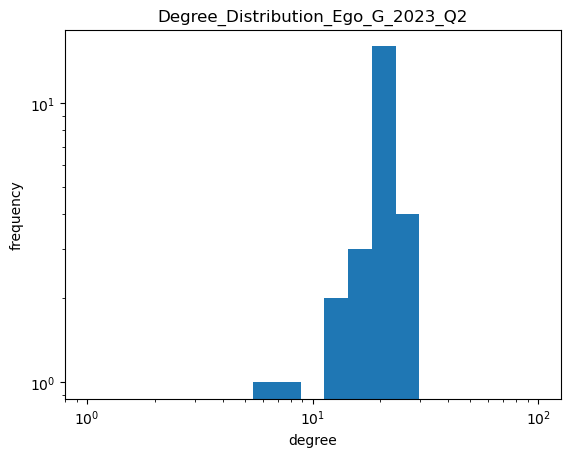

<Figure size 1500x300 with 0 Axes>

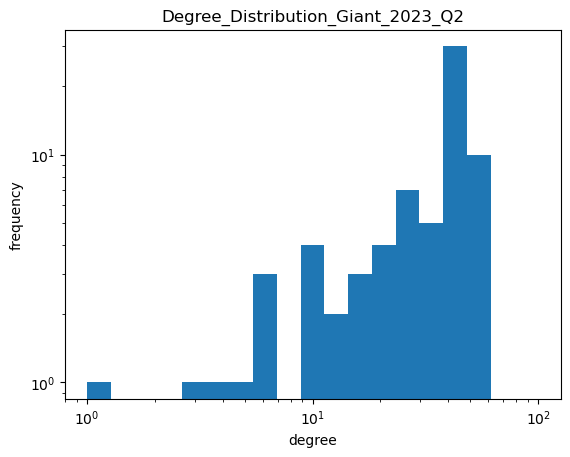

<Figure size 1500x300 with 0 Axes>

In [38]:
#CODE HERE

# Degree Distribution
# The plotter is using 20 bins, 10 bins for every 10^(n-1) - 10^n span
plot_degree_distribution(Ego_G_2023_Q2.degree(), "Degree_Distribution_Ego_G_2023_Q2")
plot_degree_distribution(Giant_2023_Q2.degree(), "Degree_Distribution_Giant_2023_Q2")

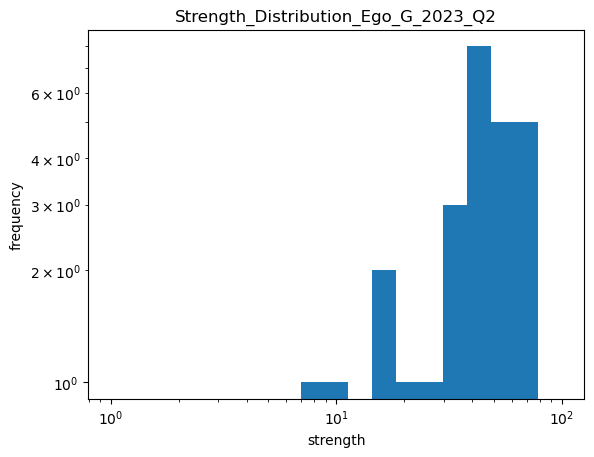

<Figure size 1500x300 with 0 Axes>

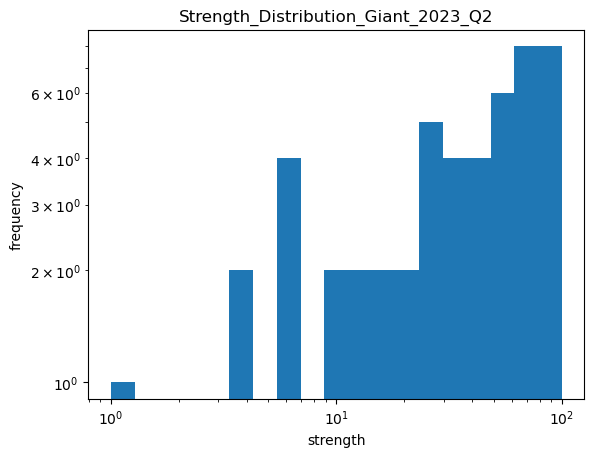

<Figure size 1500x300 with 0 Axes>

In [39]:
# Strength Distribution
plot_strength_distribution(nx.get_node_attributes(Ego_G_2023_Q2, "strength"), 'Strength_Distribution_Ego_G_2023_Q2')
plot_strength_distribution(nx.get_node_attributes(Giant_2023_Q2, "strength"), 'Strength_Distribution_Giant_2023_Q2')


### Degree Distribution Analysis, Similarities, and Difference

1. Both Ego and Giant Component Degree Distribution have similar pattern, which is a Concave Curve. This curve is actually representing Assortative pattern, where nodes tend to connect to nodes with similar interest. This makes sense since we are building the network using Assortativity approach, where two investment companies are connected if they invest in a same company. Or in another word, a Homophilious Network
2. The slight dip of frequency at the high degree node of both Ego and Giant Component Degree Distribution is an indication that the distribution has Left-skewed Distribution. This means there are many high degree nodes or hubs within the network
3. The fact that in task 2.2 we notice high value of Clustering pattern, this might related to the reason why degree distribution is left-skewed. Using these information, we can hypothesize that hubs explained in point 2 above are exhaustively connected among each other, creating Multi-node Hub. This can explain the phenomenon observed in which more nodes exist in the higher degree
4. Ego Network's Degree Distribution has smoother curve compared to Giant Component’s Degree Distribution. This is expected since Ego Network have less nodes and edges compared to Giant Component in general, which resulting a smoother curve without significant defiance

### Strength Distribution Analysis, Similarities, and Difference

1. Both Ego Network and Giant Component Strength Distribution have similar pattern as Degree Distribution, which is Concave Curve. This makes sense as more degree result more strength in general for a particular node. The strength distribution is also having Left-Skewed Distribution, which explainable by task 3.1.2
2. However, there is huge dip in the middle of the Strength Distribution for both Ego and Giant Component. This makes sense since in Strength Distribution we are taking in the weight factors into account. As we take a look into the Degree Distribution graphs once more, we can see that there is also a little dip in the middle of the graph. The extremeness is the result of weight factor. Not only that that nodes residing in that area has less degree, but also the weight of their edges are low value


**Task 3.2 (7 marks)** </br> 
Based on degree distributions and the results you obtained, what type of network would you say the whole network and ego-network are (e.g scale free, random, etc)? Could have they been generated by any of the models discussed in class? Motivate your answer.

In [40]:
#CODE HERE
GiantAvgL = nx.average_shortest_path_length(Giant_2023_Q2)
EgoAvgL = nx.average_shortest_path_length(Ego_G_2023_Q2)

GiantAvgLTheoretical = math.log10(Giant_2023_Q2.number_of_nodes())
EgoAvgLTheoretical = math.log10(Ego_G_2023_Q2.number_of_nodes())

data = [["Giant Component", GiantAvgL, GiantAvgLTheoretical],
        ["Ego Network", EgoAvgL, EgoAvgLTheoretical]]

print (tabulate(data, headers=["Network Name", 
                               "Avg. L", 
                               "Theoretical Avg. L"
                              ]))



Network Name       Avg. L    Theoretical Avg. L
---------------  --------  --------------------
Giant Component   1.56455               1.85733
Ego Network       1.23932               1.43136


In [41]:
GiantClustering = nx.average_clustering(Giant_2023_Q2)
EgoClustering = nx.average_clustering(Ego_G_2023_Q2)

data = [["Giant Component", GiantClustering, 1],
        ["Ego Network", EgoClustering, 1]]

print (tabulate(data, headers=["Network Name", 
                               "Avg. Clustering", 
                               "Max Clustering"
                              ]))

Network Name       Avg. Clustering    Max Clustering
---------------  -----------------  ----------------
Giant Component           0.701804                 1
Ego Network               0.863614                 1


**Discuss:**

### Type of Network for the selected Whole Network and Ego Network

As stated in the previous section, the selected Whole Network and Ego Network is Homophilious Network, which has same characteristics as Real-World Social Network (Szymon Talagaa & Andrzej Nowakb 2020). Although in Real-World Social Network usually the degree distribution is right-skewed rather than left-skewed, but they both possess same homophily tendency in which similar nodes tend to form community since the edge representing common and shared interest. The left-skewed characteristic appear due to the existence of Community Hub and characteristic of edge that representing similarities instead of actual distance.

When we try to calculate average of shortest path, we found out both Giant Component and Ego Network is following Log(nodes) value.

Also when we try to calculate average of clustering, we found out both Giant Component and Ego Network have high value as well, confirming Clustering Assortativity behavior.

With these characteristics
1. Homophilious Network, which has same characteristic as Real-World Social Network
2. High Clustering value due to dominant Clustering Assortativity 
3. Presence of Multi-node Hub / Community Hub with high Density and Degree
4. Left-Skewed Distribution (non Power Law)
5. Average Shortest path follows Log value of number of Nodes

we can conclude both Giant Component and Ego Network is a **Small World Networks**. Therefore, it can be recreated using **WS Network Model**.

#### Part 4: Changes of the network statistics during the pandemic

**Task 4.1 (15 marks)** </br> Plot the temporal evolution of the quantities you computed in Part 2 for the ego network and the whole network compare the difference between the networks. For each quantity, discuss if it can be used for analysing the investment patterns of Bruce Berkowitz - Fairholme Capital over time. Based on your discussion, choose the quantities that you find important. What information you can draw about the change of those network statistics during the pandemic?

In [42]:
import plotly.express as px

#CODE HERE
def plot_evolution(data1, data2, title):
    d1 = {'Type': "Whole Network", 'Quarter': list(data1.keys()), 'Value': list(data1.values())}
    df1 = pd.DataFrame(data=d1)
    
    d2 = {'Type': "Ego Network", 'Quarter': list(data2.keys()), 'Value': list(data2.values())}
    df2 = pd.DataFrame(data=d2)

    newdf = pd.concat([df1, df2])
    
    fig = px.line(newdf, x = 'Quarter', y = 'Value', title = title, markers = True, color='Type')

    fig.show()

In [43]:
plot_evolution({key:quarterData['nodesCount'] for (key, quarterData) in summaryWholeAllTime.items()},
               {key:quarterData['nodesCount'] for (key, quarterData) in summaryEgoAllTime.items()},
               '#Nodes Evolution')

#### Discussion
The evolution of number of nodes in Ego Network can give us initial idea about BBFC trial-and-error and portfolio diversification which exposing their investment strategy during a period of time.

From Q1 2019 until Q4 2019 (Pre-Covid), we can see that there is steady increase in number of Nodes for Ego Network that also align with the the increase of the number of nodes in the Whole Network. This makes sense as new investment companies are joining and they might influence or get influenced by BBFC.

However, there are significant increases of the number of nodes for Ego Network from Q1 2020 until Q4 2021 (During Covid), even though there is no changes at all in the number of nodes of Whole Network. It means BBFC direct neighbors is increasing. This indicates the BBFC aggressive trial-and-error and portfolio diversification strategy during Covid mentioned in task 2.2, so this graph confirms our hypothesis.

From Q1 2022 to Q2 2023, there exponential decline of the number of nodes for Ego Network. In 2022, although Covid variants like Delta and Omicron were still ravaging, but almost everyone in the world already took their first dose of vaccine and half of them already took their second dose. Although the number of death was still high, but the exponential increase was finally stopped and start to show sign of slowing down. Align with this, the global economy also showing positive trend, showing stability after 2 years since Covid hit. This is also reflected in BBFS investment maneuveur where they start slowing down on their aggressive trial-and-error and also portfolio diversification.

Verdict : **Important Quantities**

In [44]:
plot_evolution({key:quarterData['edgesCount'] for (key, quarterData) in summaryWholeAllTime.items()},
               {key:quarterData['edgesCount'] for (key, quarterData) in summaryEgoAllTime.items()},
               '#Edges Evolution')

#### Discussion
The evolution of number of edges in Ego Network has duplicate meaning with evolution of number of nodes, as the number of nodes in the network increase so does the edges. In this case, that also confirmed by the patterns that are exactly the same between those two quantities (steady increase in Pre-Covid, significant increase between beginning of 2020 to end of 2021, and exponential decline from 2022 to 2023). The pattern confirms the BBFC aggressive trial-and-error and portfolio diversification strategy during Covid, although from 2022 onward they start to slow down

Verdict : **Important Quantities, but choose either this quantity or number of nodes**

In [45]:
plot_evolution({key:quarterData['density'] for (key, quarterData) in summaryWholeAllTime.items()},
               {key:quarterData['density'] for (key, quarterData) in summaryEgoAllTime.items()},
               'Density Evolution')

#### Discussion
While the evolution of number of nodes and edges can give us preliminary idea about BBFC trial-and-error and portfolio diversification, the evolution of density in Ego Network can give us a more in-depth insight about how BBFC construct their strategy and maneuvers.

From Q1 2019 until Q4 2019 (Pre-Covid), we can see that the Ego Network Density is very high with 3 out 4 quarters they are reaching maximum density. This is contrast if we take a look into Whole Network Density. In fact Whole Network is quite dense but not as dense as BBFC Ego Network. This means before Covid, BBFC was having an exclusive group of investment companies that influenced or got influenced by them. Additionally, high density means almost all nodes within the Ego Network are connected to each other. This actually confirms our claim in Task 3.1.2 about the potential existence of Multi-node Hub and it exists in the Ego Network, which mean BBFC is heavily influencing or getting influenced by the Multi-node Hub. Although in Task 3.1.2 we are only taking Q2 2023 data, but overall density of BBFC Ego Network from 2019 to 2023 are high so our claim is still valid. This will later be confirmed further in Average Clustering as well.

There is significant dip from Q1 2020 until Q4 2021, where massive increase of nodes and edges is also happening in this time frame. This means BBFC Multi-node Hub starts becoming more inclusive toward other investment companies as part of BBFC trial-and-error and portfolio diversification strategy. There is also exponential increase from Q1 2022 to Q2 2023, indicating BBFC slowing down their trial-and-error and portfolio diversification (as indicated in evolution of number of nodes and edges), and the hub starts becoming more exclusive. Both claims are confirmed by the pattern that we see in evolution of nodes and edges above.

Verdict : **Important Quantities**

In [46]:
plot_evolution({key:quarterData['averageClustering'] for (key, quarterData) in summaryWholeAllTime.items()},
               {key:quarterData['averageClustering'] for (key, quarterData) in summaryEgoAllTime.items()},
               'Avg. Clustering Evolution')

#### Discussion
The evolution of average clustering in Ego Network has duplicate meaning with evolution of density, as high clustering in a network will result high density. In this case, that also confirmed by the patterns that are exactly the same between those two quantities (Maximum value in Pre-Covid, significant decrease between beginning of 2020 to end of 2021, exponential increase from 2022 to 2023, and less clustered Whole Network compared to Ego Network). The pattern confirms the potential existence of Multi-node Hub.

Verdict : **Important Quantities, but choose either this quantity or Density**

In [47]:
plot_evolution({key:quarterData['averageDegrees'] for (key, quarterData) in summaryWholeAllTime.items()},
               {key:quarterData['averageDegrees'] for (key, quarterData) in summaryEgoAllTime.items()},
               'Avg. Degrees Evolution')

#### Discussion
Degree value of a node is actually affected by two factors, number of node available in the network and the network density. The higher the number of node in a network will potentially increase the average degree of that particular network. However, the one that affirm the increase is actually the density. If the number of nodes is increasing, but the density is decreasing, then potentially the average degree will either be stagnant or even decreasing. However, if the number of nodes is increasing, but the density is either stagnant or even increasing, then we can confirm that the average degree of that network also increasing. This theory can give us confirmations on BBFC strategy and maneuvers hypothesis.

From Q1 2019 until Q2 2023, we can see that the average degree of Ego Network slowly but surely takes up a higher portion of the average degree of Whole Network. In Q1 2019, average degree of Whole Network is 30 while Ego Network is 11. This means Ego Network average degrees contributes 36.7% to the Whole Network average degrees. However in Q2 2023, average degree of Whole Network is 33 while Ego Network is 20. This means Ego Network average degrees contributes 60.6% to the Whole Network average degrees, settling an increase of 23.9% over the span of 4.5 years. This confirm our previous hypothesis about BBFC Multi-node Hub starts becoming more inclusive, especially during Covid.

Verdict : **Supporting Quantities**


In [48]:
plot_evolution({key:quarterData['averageStrength'] for (key, quarterData) in summaryWholeAllTime.items()},
               {key:quarterData['averageStrength'] for (key, quarterData) in summaryEgoAllTime.items()},
               'Avg. Strength Evolution')

#### Discussion
The evolution of average strength in Ego Network has duplicate meaning with evolution of average degree, as higher degree of a node will result higher edge and strength. In this case, that also confirmed by the patterns that are exactly the same between those two quantities (average strength of Ego Network takes up a higher portion of the average strength of Whole Network). The pattern confirms the inclusivity tendency of the BBFC Multi-node Hub.

Verdict : **Supporting Quantities**


In [49]:
plot_evolution({key:quarterData['degreeAssortativity'] for (key, quarterData) in summaryWholeAllTime.items()},
               {key:quarterData['degreeAssortativity'] for (key, quarterData) in summaryEgoAllTime.items()},
               'Degree Assortativity Evolution')

In [50]:
plot_evolution({key:quarterData['strengthAssortativity'] for (key, quarterData) in summaryWholeAllTime.items()},
               {key:quarterData['strengthAssortativity'] for (key, quarterData) in summaryEgoAllTime.items()},
               'Strength Assortativity Evolution')

In [51]:
plot_evolution({key:quarterData['clusteringAssortativity'] for (key, quarterData) in summaryWholeAllTime.items()},
               {key:quarterData['clusteringAssortativity'] for (key, quarterData) in summaryEgoAllTime.items()},
               'Clustering Assortativity Evolution')

#### Discussion
While the evolution of density and average Clustering in Ego Network can give us a more in-depth insight about how BBFC construct their strategy and maneuvers, the evolution of Assortativity in Ego Network should be able to give us a more in-depth insight about what BBFC uses to construct their strategy and maneuvers. Assortativity will measure several factors that enable BBFC to influence or got influenced by other investment companies.

However, from the graphs above, we can see almost all types of Assortativity measured (Degree, Strength, and Clustering) for Ego Network has negative values across all time. In contrast, we can see Whole Network’s Assortative values are all positive and dominated by Clustering Assortativity. There is some exception like in Q1 2020 in which Ego Network has tremendous amount of Clustering Assortativity. This marks the period when Covid hits and BBFC starts their trial-and-error effort to survive the blow. Therefore, it confirms our hypothesis in Task 2.2.2 point 4, where BBFC starts experimenting with Clustering Assortativity because it is the dominant Assortativity factor of Whole Network.

Verdict : **Trivial Quantities, due to the lack of evidence on the usage of Assortativity in BBFC strategy**


### Conclusion
We are classifying the statistic quantities above into 3 categories
1. Important Quantities : Essential to gain knowledge from the network
<br>&emsp; - Number of Nodes and Edges
<br>&emsp; - Density and Average Clustering
2. Supporting Quantities : Essential to prove our hypothesis or cement our initial idea about the network
<br>&emsp; - Average Degree and Average Strength
3. Trivial Quantities : Not useful due to lack of data or proving points
<br>&emsp; - Degree Assortativity
<br>&emsp; - Strength Assortativity
<br>&emsp; - Clustering Assortativity

Based on the observed patterns in the evolution of statistic quantities above, we can draw several conclusions
1. To deal with Covid disruption in the investment market, BBFC decided to aggressively doing trial-and-error and portfolio diversification from Q1 2020 until Q4 2021. The pattern changed from 2022 onward as they start to slow down on doing the trial-and-error and portfolio diversification
2. Existence of Multi-node Hub in the network and it is located inside of BBFC Ego Network. This hub is potentially affecting the way BBFC strategizes their maneuvers
3. BBFC exclusivity strategy start to becoming from inclusive during Covid, but it tends to change back to exclusive especially if we see pattern from the last 2 quarters

**Tasks 4.2 (10 marks)** </br> Choose a suitable centrality measure that would give us imporatnt information about the nodes in the whole network, and clearly motivate your choice. Use this measure to find the 3 most central nodes for each quarter. Compare the centrality of Bruce Berkowitz - Fairholme Capital overtime with that of the most central nodes. What can you conclude from this?

In [52]:
def sort_degree_and_slice(network, slice=3):
    sortedDegree = [(id, val) for id, val in sorted(network.degree(), key = lambda p: -p[1])]
    summary = sortedDegree[:slice]
    summary.append(('Bruce Berkowitz - Fairholme Capital', 
                    network.degree('Bruce Berkowitz - Fairholme Capital'), 
                    ))
    summary.append(str(sortedDegree.index(('Bruce Berkowitz - Fairholme Capital', 
                                       network.degree('Bruce Berkowitz - Fairholme Capital')))) + "/" + str(network.number_of_nodes()))

    return summary

pd.DataFrame({
    'Q1_2019': sort_degree_and_slice(G_2019_Q1),
    'Q2_2019': sort_degree_and_slice(G_2019_Q2),
    'Q3_2019': sort_degree_and_slice(G_2019_Q3),
    'Q4_2019': sort_degree_and_slice(G_2019_Q4),
    'Q1_2020': sort_degree_and_slice(G_2020_Q1),
    'Q2_2020': sort_degree_and_slice(G_2020_Q2),
    'Q3_2020': sort_degree_and_slice(G_2020_Q3),
    'Q4_2020': sort_degree_and_slice(G_2020_Q4),
    'Q1_2021': sort_degree_and_slice(G_2021_Q1),
    'Q2_2021': sort_degree_and_slice(G_2021_Q2),
    'Q3_2021': sort_degree_and_slice(G_2021_Q3),
    'Q4_2021': sort_degree_and_slice(G_2021_Q4),
    'Q1_2022': sort_degree_and_slice(G_2022_Q1),
    'Q2_2022': sort_degree_and_slice(G_2022_Q2),
    'Q3_2022': sort_degree_and_slice(G_2022_Q3),
    'Q4_2022': sort_degree_and_slice(G_2022_Q4),
    'Q1_2023': sort_degree_and_slice(G_2023_Q1),
    'Q2_2023': sort_degree_and_slice(G_2023_Q2),
}).rename(index={0: "1st", 1: "2nd", 2: "3rd", 3: "BBFC Degree", 4: "BBFC Rank"}).T

1st  \
Q1_2019    (Wallace Weitz - Weitz Value Fund, 50)   
Q2_2019    (Wallace Weitz - Weitz Value Fund, 54)   
Q3_2019    (Wallace Weitz - Weitz Value Fund, 51)   
Q4_2019  (Christopher Davis - Davis Advisors, 56)   
Q1_2020  (Christopher Davis - Davis Advisors, 61)   
Q2_2020  (Christopher Davis - Davis Advisors, 59)   
Q3_2020   (Bill Nygren - Oakmark Select Fund, 58)   
Q4_2020  (Christopher Davis - Davis Advisors, 60)   
Q1_2021  (Christopher Davis - Davis Advisors, 60)   
Q2_2021  (Christopher Davis - Davis Advisors, 59)   
Q3_2021   (Bill Nygren - Oakmark Select Fund, 58)   
Q4_2021  (Christopher Davis - Davis Advisors, 59)   
Q1_2022  (Christopher Davis - Davis Advisors, 60)   
Q2_2022   (Bill Nygren - Oakmark Select Fund, 58)   
Q3_2022   (Bill Nygren - Oakmark Select Fund, 60)   
Q4_2022   (Bill Nygren - Oakmark Select Fund, 58)   
Q1_2023   (Bill Nygren - Oakmark Select Fund, 60)   
Q2_2023   (Bill Nygren - Oakmark Select Fund, 56)   

                                                    2nd  \
Q1_2019         (Francois Rochon - Giverny Capital, 49)   
Q2_2019  (Glenn Greenberg - Brave Warrior Advisors, 53)   
Q3_2019         (Francois Rochon - Giverny Capital, 50)   
Q4_2019         (Bill Nygren - Oakmark Select Fund, 54)   
Q1_2020         (Francois Rochon - Giverny Capital, 60)   
Q2_2020  (Glenn Greenberg - Brave Warrior Advisors, 59)   
Q3_2020        (Christopher Davis - Davis Advisors, 58)   
Q4_2020         (Bill Nygren - Oakmark Select Fund, 57)   
Q1_2021         (Bill Nygren - Oakmark Select Fund, 56)   
Q2_2021         (Steven Romick - FPA Crescent Fund, 58)   
Q3_2021        (Christopher Davis - Davis Advisors, 58)   
Q4_2021         (Bill Nygren - Oakmark Select Fund, 55)   
Q1_2022         (Bill Nygren - Oakmark Select Fund, 58)   
Q2_2022        (Christopher Davis - Davis Advisors, 56)   
Q3_2022        (Christopher Davis - Davis Advisors, 59)   
Q4_2022        (Christopher Davis - Davis Advisors, 58)   
Q1_2023        (Christopher Davis - Davis Advisors, 60)   
Q2_2023        (Christopher Davis - Davis Advisors, 55)   

                                                    3rd  \
Q1_2019  (Glenn Greenberg - Brave Warrior Advisors, 49)   
Q2_2019         (Bill Nygren - Oakmark Select Fund, 52)   
Q3_2019   (Thomas Gayner - Markel Asset Management, 50)   
Q4_2019   (Thomas Gayner - Markel Asset Management, 54)   
Q1_2020  (Glenn Greenberg - Brave Warrior Advisors, 57)   
Q2_2020          (David Rolfe - Wedgewood Partners, 57)   
Q3_2020          (David Rolfe - Wedgewood Partners, 58)   
Q4_2020       (David Tepper - Appaloosa Management, 57)   
Q1_2021                   (Viking Global Investors, 56)   
Q2_2021         (Bill Nygren - Oakmark Select Fund, 57)   
Q3_2021        (David Katz - Matrix Asset Advisors, 55)   
Q4_2021  (Glenn Greenberg - Brave Warrior Advisors, 55)   
Q1_2022         (Steven Romick - FPA Crescent Fund, 57)   
Q2_2022         (Steven Romick - FPA Crescent Fund, 54)   
Q3_2022         (Steven Romick - FPA Crescent Fund, 57)   
Q4_2022   (Thomas Gayner - Markel Asset Management, 56)   
Q1_2023   (Thomas Gayner - Markel Asset Management, 57)   
Q2_2023                        (Hillman Value Fund, 54)   

                                       BBFC Degree BBFC Rank  
Q1_2019  (Bruce Berkowitz - Fairholme Capital, 11)     60/71  
Q2_2019  (Bruce Berkowitz - Fairholme Capital, 13)     59/73  
Q3_2019  (Bruce Berkowitz - Fairholme Capital, 15)     59/74  
Q4_2019  (Bruce Berkowitz - Fairholme Capital, 14)     61/77  
Q1_2020  (Bruce Berkowitz - Fairholme Capital, 17)     60/77  
Q2_2020  (Bruce Berkowitz - Fairholme Capital, 20)     58/77  
Q3_2020  (Bruce Berkowitz - Fairholme Capital, 28)     53/77  
Q4_2020  (Bruce Berkowitz - Fairholme Capital, 32)     48/77  
Q1_2021  (Bruce Berkowitz - Fairholme Capital, 29)     49/77  
Q2_2021  (Bruce Berkowitz - Fairholme Capital, 35)     43/77  
Q3_2021  (Bruce Berkowitz - Fairholme Capital, 32)     45/77  
Q4_2021  (Bruce Berkowitz - Fairholme 

**Discuss:**

### Reasoning
1. I am picking Degree Centrality to calculate the importance of node in the network because in Task 4.1 we confirm the existence of Multi-node Hub. To be able to find this Hub, Degree is the most logical option to take. Also finding Hub in this type of network hold significant meaning, since it is the nodes that influence or got influenced by most nodes which can help us strategize ourselves whenever we want to enter the market
2. I am picking Whole Network to cover potential highest degree node live in non Giant Component. Also since I am taking Degree Centrality, there is no need to take care of unconnected part since there is no path involved in the calculation of the Centrality

### Conclusion
From the Task 4.2.1, we can see the shift of hubs from Wallace Weltz - Weltz Value Fund (WWWV) and Francois Rochon - Giverny Capital (FRGC) to Bill Nygren - Oakmark Select Fund (BNOS) and Christoper Davis - Davis Advisors (CDDA). This happen in the span of 4.5 years, from Q1 2019 until Q2 2023. However, from the BBFC Rank, we can see that BBFC is actually not included in the Multi-node hub as its rank and degree value are so far apart from the top three. Combining this with second point in Task 4.1.8, we can conclude that the shift of these companies will affect BBFC strategy. Additionally, to understand near-future BBFC maneuvers better, we can also take deeper look into BNOS and CDDA as they are the latest hubs in the network

Also we can see the increase of BBFC degree value especially during Covid, which happen from Q1 2020 until Q4 2021. This is also making BBFC becoming more central than before, as proven by the BBFC rank column in the same timespan. However the value and the rank start dropping from Q1 2022 onward. It actually confirm first point in Task 4.1.8, in which it reflects BBFC strategy to do aggressive trial-and-error and portfolio diversification during Covid. It also confirm third point in Task 4.1.8, in which it reflects BBFC strategy to be more inclusive during Covid.

#### Part 5: Clustering and Modularity

**Task 5.1 (15 marks)** </br> Find the communities in each quarter in the whole network. To do so, use an algorithm of your choice, and justify your decision. Analyse how the communities evolve overtime, focussing on the membership of Bruce Berkowitz - Fairholme Capital. Does this node fall in the same community with the same superinvestors across different quarters? What conclusions can you draw from this?

In [93]:
#CODE HERE

def create_partition_map(partition):
    partition_map = {}
    for idx, cluster_nodes in enumerate(partition):
        for node in cluster_nodes:
            partition_map[node] = idx
    return partition_map

def get_BBFC_community(partitionMap):
    BBFC_community_index = partition_map.get("Bruce Berkowitz - Fairholme Capital")

    BBFC_community = []

    for key, value in partition_map.items():
        if value == BBFC_community_index:
            BBFC_community.append(key)
    
    return BBFC_community

def is_in_community(community, values):
    communityDict = {}
    for val in values:
        if val in community:
            communityDict[val] = True
        else:
            communityDict[val] = False

    return communityDict

In [94]:
# Detect communities using the Louvain method
communities = nx.community.louvain_communities(G_2023_Q2)

partition_map = create_partition_map(communities)

BBFC_community = get_BBFC_community(partition_map)

print(is_in_community(BBFC_community, ['Bill Nygren - Oakmark Select Fund', 'Christopher Davis - Davis Advisors', 'kontol']))

{'Bill Nygren - Oakmark Select Fund': True, 'Christopher Davis - Davis Advisors': True, 'kontol': False}


In [ ]:

# Drawing Network with Community
# node_colors = [two_cluster_partition_map[n] for n in G_2019_Q1.nodes()]

# draw_community(G_2019_Q1, 'Community_G_2019_Q1', node_colors)

**Discuss:**

#### Part 6: Report your findings

**Task 6.1 (10 marks)** </br> As any good DBBA Capital data analyst, at the end of your analysis you need to present your fidnings. Please write a brief (~250 words) report discussing how the portfolio of Fairholme Capital has changed compared with the rest of the funds in the dataset.

**REPORT**


## REFERENCES

Szymon Talagaa and Andrzej Nowakb. (2020). Homophily as a Process Generating Social Networks: Insights from Social Distance Attachment Model. https://www.jasss.org/23/2/6.html

http://www.analytictech.com/networks/egonet.htm#:~:text=Ego%20networks%20consist%20of%20a,form%20The%20human%20social%20network.